## Masters Project Final

### Importing Libraries

In [1]:
import sys
!{sys.executable} -m pip install pmdarima

  Obtaining dependency information for numpy>=1.21.2 from https://files.pythonhosted.org/packages/1a/2e/151484f49fd03944c4a3ad9c418ed193cfd02724e138ac8a9505d056c582/numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 13.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [2]:
import pmdarima
print(pmdarima.__version__)  # Check if it prints the version

2.0.4


In [3]:
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Get contents from csv file
train_df = pd.read_csv("train.csv", header=0)
# test_df = pd.read_csv("/kaggle/input/walmart-sales-forecast/test.csv", header=0)  # no labels; we will not use
store_df = pd.read_csv("stores.csv", header=0)
feature_df = pd.read_csv("features.csv", header=0)
us_holiday_df = pd.read_csv("US Holiday Dates (2004-2021).csv", header=0)

In [6]:
# Check min and max date for data period
print(train_df["Date"].min(), train_df["Date"].max())
# Length of data
print(len(train_df))

2010-02-05 2012-10-26
421570


In [7]:
# display irregular sales (some interval between weeks and negative values)
train_df[(train_df["Store"]==45) & (train_df["Dept"]==47)]

,Store,Dept,Date,Weekly_Sales,IsHoliday
417801,45,47,2010-02-26,-1750.00,False
417802,45,47,2010-05-28,100.00,False
417803,45,47,2010-09-24,70.00,False
417804,45,47,2010-12-24,124.00,False
417805,45,47,2011-02-11,0.00,True
417806,45,47,2011-03-25,20.00,False
417807,45,47,2011-04-08,20.00,False
417808,45,47,2011-05-13,20.00,False
417809,45,47,2011-11-18,-24.00,False
417810,45,47,2011-12-23,95.00,False


## Preprocessing

### Get Unique store-product combinations for imputation

In [8]:
combinations = train_df[["Store", "Dept"]].drop_duplicates()
combinations

# Shallow copy
process_df = train_df.copy()
# Date column > Date type
process_df["Date"] = pd.to_datetime(process_df["Date"])
# Set date column as index
process_df.set_index("Date", inplace=True)
# Sorting by index (date) for filtering on later process
process_df.sort_index(inplace=True)

p_df_resampled_list = []

# Imputation no sales bewteen certian week by zero 
for _, row in combinations.iterrows():
    store_id = row["Store"]
    dept = row["Dept"]

    # Filter df for specific store and dept
    p_df = process_df[(process_df["Store"] == store_id) & (process_df["Dept"] == dept)]
        
    # Resample to a weekly frequency (keeping Friday) and fill missing values with zero
    p_df_resampled = p_df.resample('W-FRI').asfreq()

    # Fill previous value for store, dept and 0 for weekly sales
    p_df_resampled["Store"] = p_df_resampled["Store"].ffill()
    p_df_resampled["Dept"] = p_df_resampled["Dept"].ffill()
    p_df_resampled["Weekly_Sales"] = p_df_resampled["Weekly_Sales"].fillna(0)
        
    # Append the preprocessed group to the list
    p_df_resampled_list.append(p_df_resampled)

# Concatenate all preprocessed groups into a single DataFrame
processed_data = pd.concat(p_df_resampled_list)
# Reset index for later process
processed_data = processed_data.reset_index()

# Change data time
processed_data["Store"] = processed_data["Store"].astype(int)
processed_data["Dept"] = processed_data["Dept"].astype(int)
processed_data["Date"] = processed_data["Date"].dt.strftime("%Y-%m-%d")

# Check whether total sales changed due to the process or not.
assert abs(processed_data["Weekly_Sales"].sum()-train_df["Weekly_Sales"].sum()) < 0.01

# Store processed data as train df
train_df = processed_data
train_df

,Date,Store,Dept,Weekly_Sales,IsHoliday
0,2010-02-05,1,1,24924.50,False
1,2010-02-12,1,1,46039.49,True
2,2010-02-19,1,1,41595.55,False
3,2010-02-26,1,1,19403.54,False
4,2010-03-05,1,1,21827.90,False
...,...,...,...,...,...
449232,2012-09-28,45,98,508.37,False
449233,2012-10-05,45,98,628.10,False
449234,2012-10-12,45,98,1061.02,False
449235,2012-10-19,45,98,760.01,False


In [9]:
store_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [10]:
train_df.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday
0,2010-02-05,1,1,24924.50,False
1,2010-02-12,1,1,46039.49,True
2,2010-02-19,1,1,41595.55,False
3,2010-02-26,1,1,19403.54,False
4,2010-03-05,1,1,21827.90,False


In [11]:
feature_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### Merging three different sets

In [12]:
df = train_df.merge(feature_df, on=['Store', 'Date'], how='inner').merge(store_df, on=['Store'], how='inner')
df.head(5)

,Date,Store,Dept,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,2010-02-05,1,1,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,2010-02-05,1,2,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,2010-02-05,1,3,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,2010-02-05,1,4,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,2010-02-05,1,5,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


### Removing duplicate column

In [13]:
df.drop(['IsHoliday_y'], axis=1,inplace=True)

In [14]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) #renaming the column

In [15]:
df.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,2010-02-05,1,1,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,2010-02-05,1,2,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,2010-02-05,1,3,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,2010-02-05,1,4,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,2010-02-05,1,5,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [16]:
df.shape

(449237, 16)

### Remove less than 2 months data

In [17]:
# deine date to check continuous last 8 weeks; we will predict last 4 weeks so would like to avoid any missing sales during those periods.
max_date = max(process_df.index)
cut_date = max_date - pd.Timedelta(weeks=7, days=1)
print(max_date, cut_date)

count_train_df = process_df[cut_date:].reset_index()
count_train_df = count_train_df.groupby(["Store", "Dept"])["Date"].count().reset_index()
count_train_df = count_train_df[count_train_df["Date"]>=8]
count_train_df = count_train_df[["Store", "Dept"]]

train_df = train_df.merge(count_train_df, on=["Store", "Dept"], how="inner")
train_df

2012-10-26 00:00:00 2012-09-06 00:00:00


,Date,Store,Dept,Weekly_Sales,IsHoliday
0,2010-02-05,1,1,24924.50,False
1,2010-02-12,1,1,46039.49,True
2,2010-02-19,1,1,41595.55,False
3,2010-02-26,1,1,19403.54,False
4,2010-03-05,1,1,21827.90,False
...,...,...,...,...,...
406814,2012-09-28,45,98,508.37,False
406815,2012-10-05,45,98,628.10,False
406816,2012-10-12,45,98,1061.02,False
406817,2012-10-19,45,98,760.01,False


In [18]:
# Merge store info and features into sales data
# train
print("train data")
print("row count before merging:", train_df.shape[0])
merged_train_df = pd.merge(train_df, store_df, on='Store', how='left')
print("row count after merging store master:", merged_train_df.shape[0])
merged_train_df = pd.merge(merged_train_df, feature_df.drop(columns="IsHoliday"), on=['Store', 'Date'], how='left')
print("row count after merging features:", merged_train_df.shape[0])
# print(merged_train_df.head())


train data
row count before merging: 406819
row count after merging store master: 406819
row count after merging features: 406819


In [19]:
# Fix date to be Friday for holiday data; weekly sales is stored with Friday
def to_previous_friday(df: pd.DataFrame, date_col: str, ) -> pd.DataFrame:
    if not isinstance(df[date_col][0], pd.Timestamp):
        df[date_col] = pd.to_datetime(df[date_col])

    df[f"{date_col}"] = df[date_col].apply(lambda x: x - pd.DateOffset(days=((x.weekday() + (7-4)) % 7)))
    df = df.drop_duplicates(subset=[date_col])

    return df

us_holiday_df = to_previous_friday(us_holiday_df, "Date")
us_holiday_df["IsHoliday"] = us_holiday_df["Holiday"]
us_holiday_df = us_holiday_df[["Date", "IsHoliday"]]
us_holiday_df

,Date,IsHoliday
0,2004-07-02,4th of July
1,2005-07-01,4th of July
2,2006-06-30,4th of July
3,2007-06-29,4th of July
4,2008-07-04,4th of July
...,...,...
333,2012-04-06,Western Easter
335,2009-04-10,Western Easter
336,2020-04-10,Western Easter
337,2006-04-14,Western Easter


In [20]:
import pandas as pd

def add_more_date_feature(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    if not isinstance(df[date_col][0], pd.Timestamp):
        df[date_col] = pd.to_datetime(df[date_col])
    
    # Extract year, quarter, month and week from date
    df["year"] = df[date_col].apply(lambda x: x.year)
    df["quarter"] = df[date_col].apply(lambda x: x.quarter)
    df["month"] = df[date_col].apply(lambda x: x.month)
    df["week"] = df[date_col].apply(lambda x: x.week)

    return df

In [21]:
# Add year, quarter, month, day columns
merged_train_df = add_more_date_feature(merged_train_df, "Date")
# merged_test_df = add_more_date_feature(merged_test_df, "Date")

print("train data")
print("row count before merging:", merged_train_df.shape[0])
merged_train_df = pd.merge(merged_train_df.drop(columns="IsHoliday"), us_holiday_df, on="Date", how="left")
print("row count after merging:", merged_train_df.shape[0])
print(merged_train_df.head())
# print(merged_test_df.head())

train data
row count before merging: 406819
row count after merging: 406819
        Date  Store  Dept  Weekly_Sales Type    Size  Temperature  Fuel_Price  \
0 2010-02-05      1     1      24924.50    A  151315        42.31       2.572   
1 2010-02-12      1     1      46039.49    A  151315        38.51       2.548   
2 2010-02-19      1     1      41595.55    A  151315        39.93       2.514   
3 2010-02-26      1     1      19403.54    A  151315        46.63       2.561   
4 2010-03-05      1     1      21827.90    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   U

## Store and dept numbers

In [22]:
df['Store'].nunique()

45

In [23]:
df['Dept'].nunique()

81

### Now, I will look at the average weekly sales for each store and each department to see if there is any weird values or not. There are 45 stores and 81 departments for stores.

In [24]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,94.378083
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,165.187355
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,249.576761,15745.528252,3934.540000,336.232378,11.962500,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,188.299712
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,214.407958,19340.693986,5985.671119,667.070315,5.303462,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,182.887882
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,562.400280,34208.097273,1123.383217,4374.927902,257.237832,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,10.192000,16978.366503,6880.466434,119.946897
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,312.213592,29575.050769,3596.107762,46.581944,12.219375,NaN


### Store numbers range from 1 to 45, while department numbers span from 1 to 99, though some numbers, such as 88 and 89, are missing. In total, there are 81 departments.  

### The pivot table clearly shows incorrect values, including zero and negative weekly sales. Since sales amounts cannot be negative and it is unrealistic for a department to have no sales for an entire week, these values will be corrected.

In [25]:
df.loc[df['Weekly_Sales']<=0]

,Date,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
116,2010-02-12,1,47,0.0,NaN,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
189,2010-02-19,1,47,-863.0,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
262,2010-02-26,1,47,0.0,NaN,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
335,2010-03-05,1,47,0.0,NaN,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
409,2010-03-12,1,47,-698.0,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448875,2012-09-21,45,54,0.0,NaN,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,191.856704,8.684,B,118221
448940,2012-09-28,45,45,0.0,NaN,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
448943,2012-09-28,45,54,0.0,NaN,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
449078,2012-10-12,45,54,0.0,NaN,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221


### 1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [26]:
df = df.loc[df['Weekly_Sales'] > 0]

In [27]:
df.shape

(420212, 16)

# EDA

In [28]:
"""EDA modules"""
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


class EDA:
    """Class for General EDA.

    variables
    ----------
    df: pd.DataFrame
    target_col: str
        Target column on dataframe (only one column)
        - This column would be defined if you want to explicitly compare to other features
    ----------
    """
    def __init__(self, df: pd.DataFrame, target_col: str = None) -> None:
        """Initialize variables and define columns."""
        self._df = df
        self._tgt_col = target_col
        self._num_cols = df.select_dtypes(include="number").columns
        self._cat_cols = df.select_dtypes(include=["object", "category"]).columns
        print("Numerical columns")
        print(self._num_cols)
        print("--------")
        print("Categorical columns")
        print(self._cat_cols)
        print("--------")
        print("Target column")

    def describe_df(self) -> None:
        """Describe dataframe; info, nunique, null ratio & describe."""
        print("Overall")
        print(self._df.info())
        print("--------")
        print("Unique value count")
        print(self._df.nunique())
        print("--------")
        print("Null value rate")
        print(self._df.isnull().sum()/len(self._df)*100)
        print("--------")
        print("Describe numerical columns")
        print(self._df.describe())
        print("--------")
        if len(self._cat_cols) > 0:
            print("Describe categorical columns")
            print(self._df.describe(include="object"))
            print("--------")

    def dist_plot(self) -> None:
        """Distribution plots: histgram, boxplot & violin plot.

        If target column defined, then plots will be generated except the target column.
        """
        if self._tgt_col:
            for col in [x for x in self._num_cols if x != self._tgt_col]:
                f, ax = plt.subplots(1,3,figsize=(12,3))
                sns.histplot(self._df, x=col, ax=ax[0], kde=True, bins=20, stat="percent", hue=self._tgt_col)
                sns.boxplot(self._df, x=col, hue=self._tgt_col, ax=ax[1])
                sns.violinplot(self._df, x=col, hue=self._tgt_col, ax=ax[2], alpha=0.3)
                plt.legend()
                plt.show()

        else:
            for col in self._num_cols:
                f, ax = plt.subplots(1,3,figsize=(12,3))
                sns.histplot(self._df, x=col, ax=ax[0], kde=True, bins=20, stat="percent")
                sns.boxplot(self._df, x=col, ax=ax[1])
                sns.violinplot(self._df, x=col, ax=ax[2], alpha=0.3)
                plt.show()

    def counter_plot(self) -> None:
        """Counter plots for category features."""
        for col in self._cat_cols:
            f, ax = plt.subplots(1,1,figsize=(12,4))
            sns.countplot(data=self._df, x=col, ax=ax)
            x_labels_1 = [label.get_text() for label in ax.get_xticklabels()]
            ax.set_xticklabels(x_labels_1, rotation=45)

            plt.show()


    def pair_plot(self) -> None:
        """Pair plot"""
        if self._tgt_col:
            _ = sns.pairplot(self._df, hue=self._tgt_col)
        else:
            _ = sns.pairplot(self._df)

    def pie_plot_target(self) -> None:
        """Pie plot for target column."""
        tgt_counts = self._df[self._tgt_col].value_counts()

        plt.figure()
        plt.pie(tgt_counts, labels=tgt_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
        plt.title(f"Distribution of {self._tgt_col}")
        plt.show()

    def dist_plot_target(self) -> None:
        """Distribution plot for target column."""
        plt.figure()
        sns.histplot(self._df[self._tgt_col], kde=True)
        plt.show()

    def corr_plot(self) -> None:
        """Calculate Pearson correlation among numerical columns and plot it."""
        df_corr = self._df.corr(numeric_only=True)
        mask = np.tril(np.ones(df_corr.shape),k = -1).astype(bool)
        df_corr_fil = df_corr.where(mask)

        plt.figure(figsize=(16,16))
        sns.heatmap(df_corr_fil, annot=True, cmap="crest", fmt=".2f", linewidths=0.01)
        plt.show()

        plt.figure(figsize = (16,16))
        mask = df_corr_fil.where(abs(df_corr_fil) > 0.9).isna()
        sns.heatmap(df_corr_fil, annot=True, cmap="crest", fmt=".2f", linewidths=0.01, mask=mask)
        plt.show()


    def plot_all(self) -> None:
        """Execute all functions."""
        self.describe_df()
        # If Binary value on the target column, then create a pie plot; otherwise histogram.
        if self._tgt_col:
            if len(self._df[self._tgt_col].unique()) > 2:
                self.dist_plot_target()
            else:
                self.pie_plot_target()
        self.dist_plot()
        self.counter_plot()
        self.corr_plot()

In [29]:
eda = EDA(merged_train_df)

Numerical columns
Index(['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'year', 'quarter', 'month', 'week'],
      dtype='object')
--------
Categorical columns
Index(['Type', 'IsHoliday'], dtype='object')
--------
Target column


Overall
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406819 entries, 0 to 406818
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          406819 non-null  datetime64[ns]
 1   Store         406819 non-null  int64         
 2   Dept          406819 non-null  int64         
 3   Weekly_Sales  406819 non-null  float64       
 4   Type          406819 non-null  object        
 5   Size          406819 non-null  int64         
 6   Temperature   406819 non-null  float64       
 7   Fuel_Price    406819 non-null  float64       
 8   MarkDown1     144858 non-null  float64       
 9   MarkDown2     107469 non-null  float64       
 10  MarkDown3     132015 non-null  float64       
 11  MarkDown4     130603 non-null  float64       
 12  MarkDown5     145533 non-null  float64       
 13  CPI           406819 non-null  float64       
 14  Unemployment  406819 non-null  float64       
 15  year     

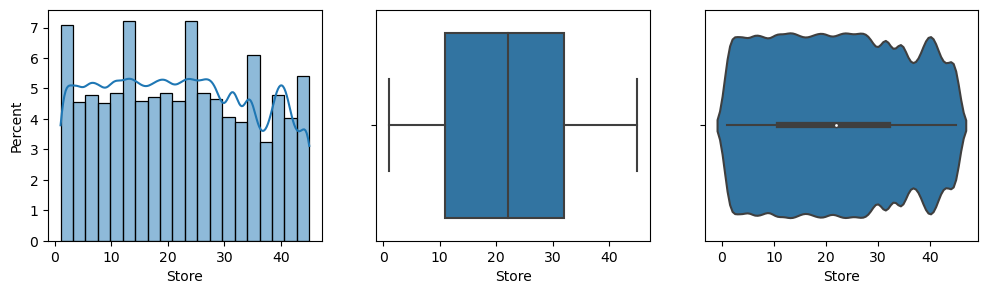

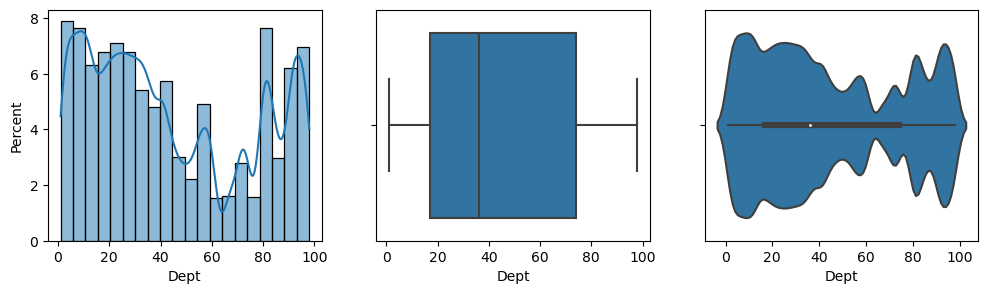

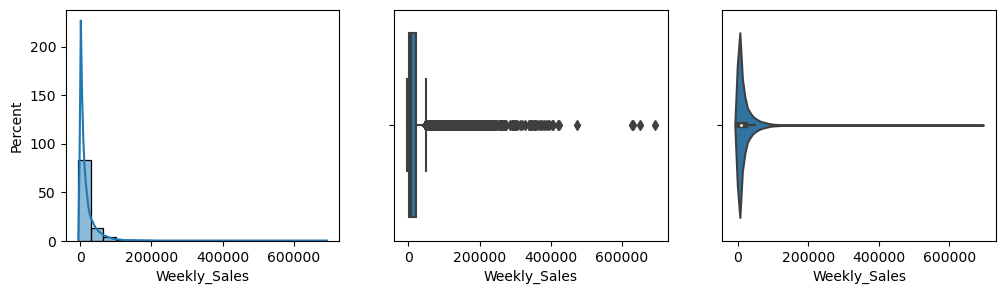

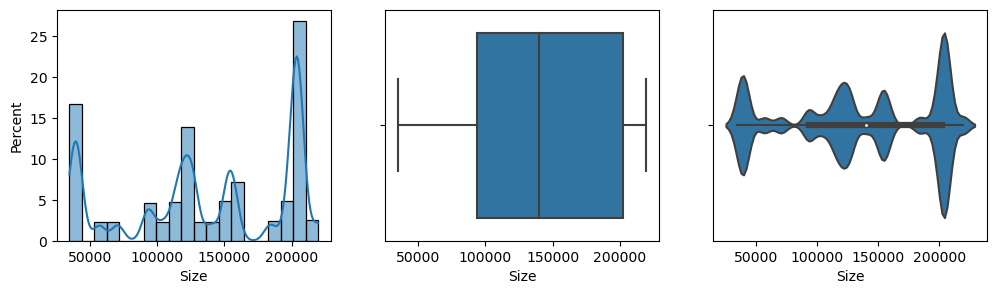

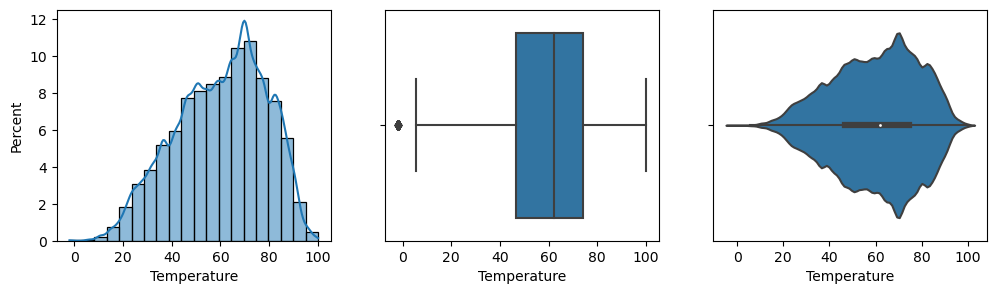

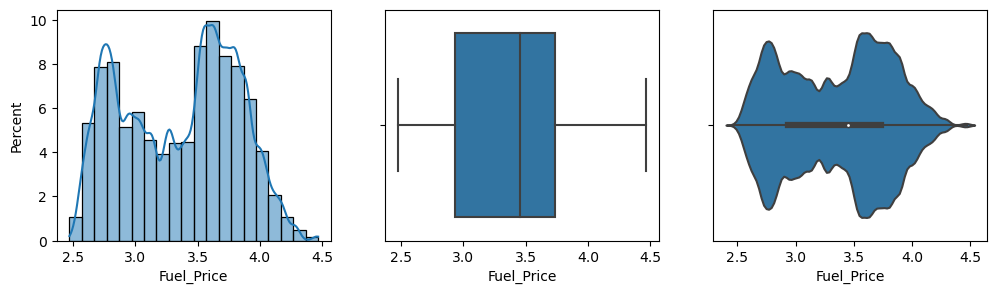

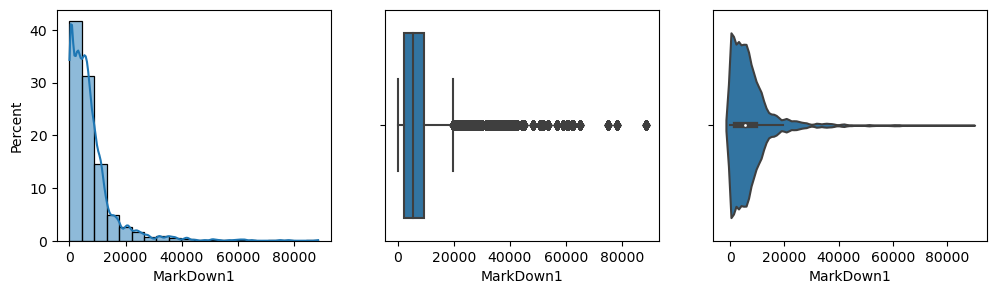

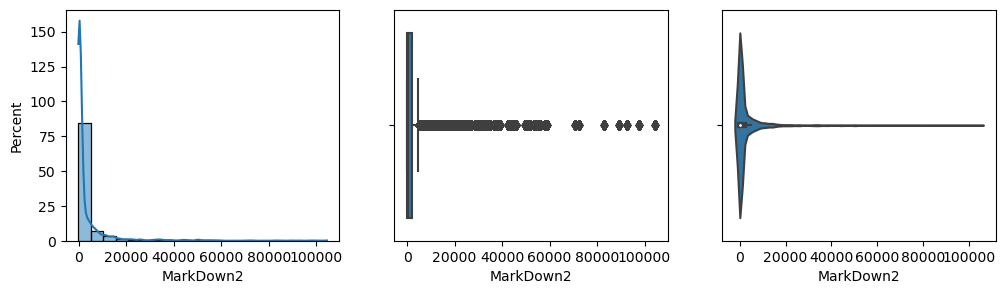

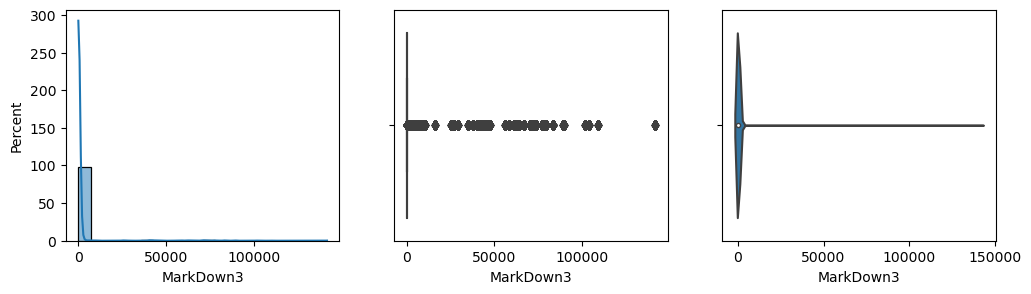

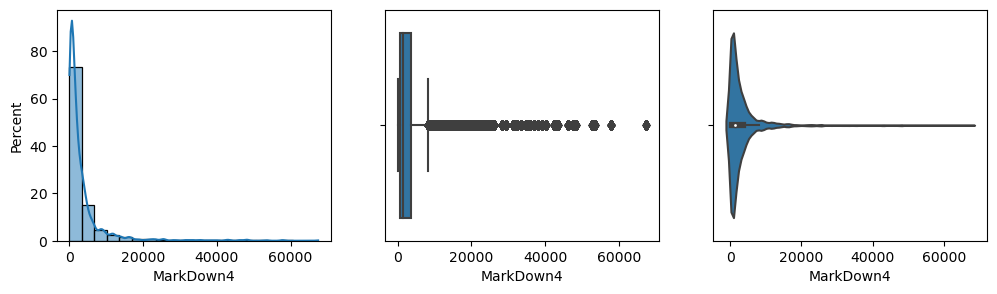

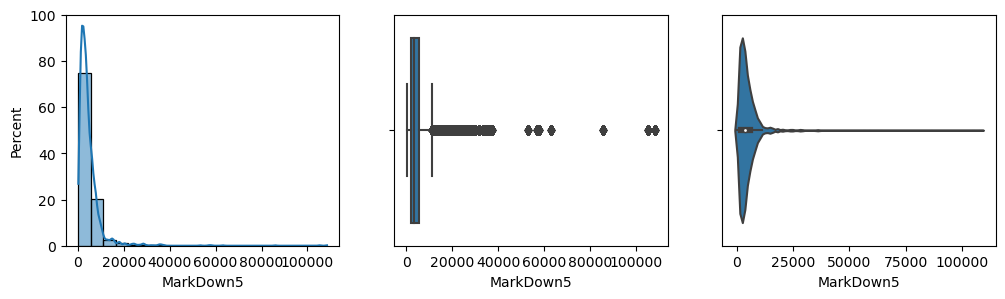

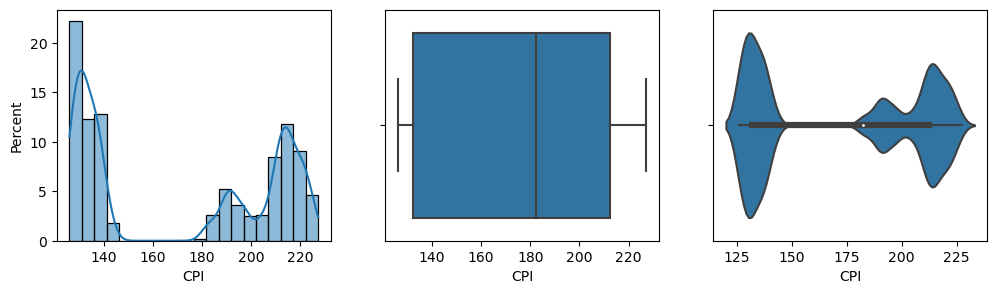

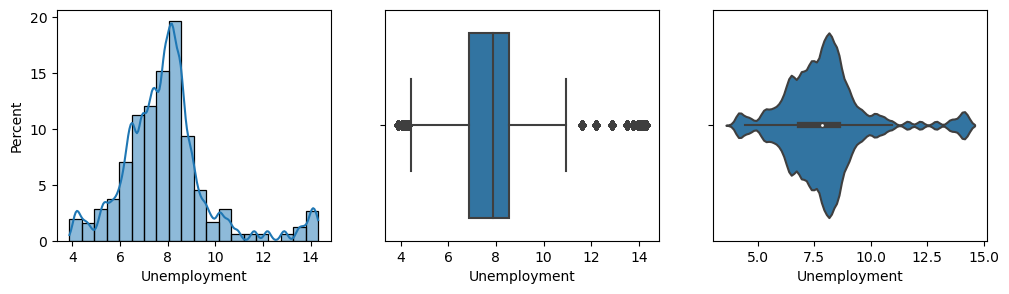

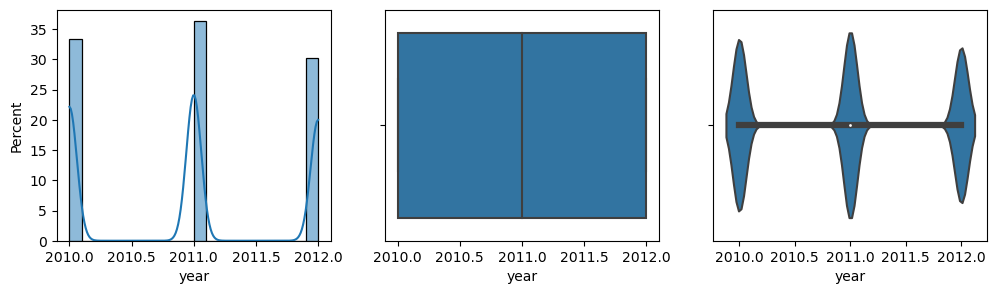

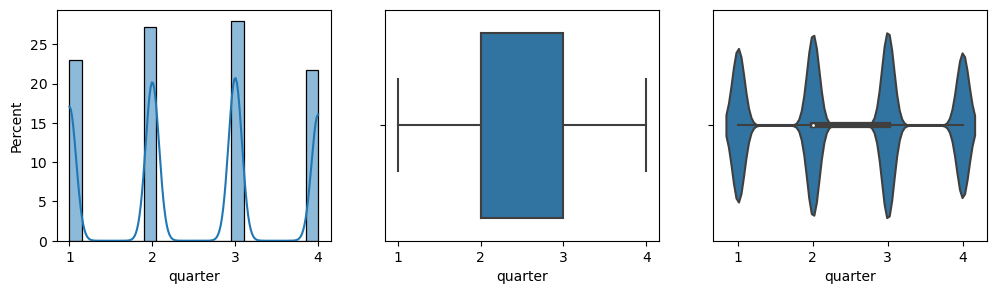

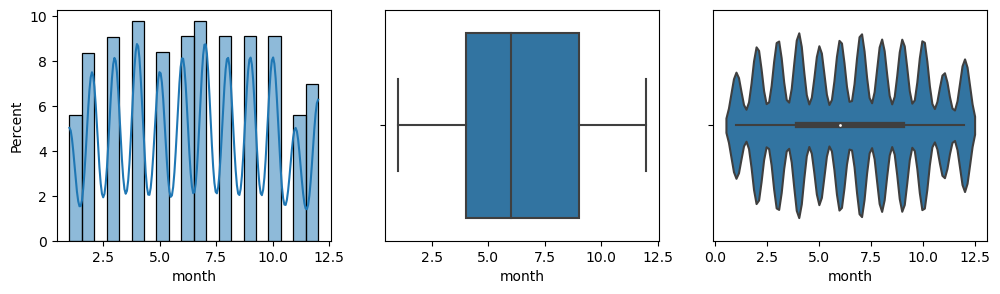

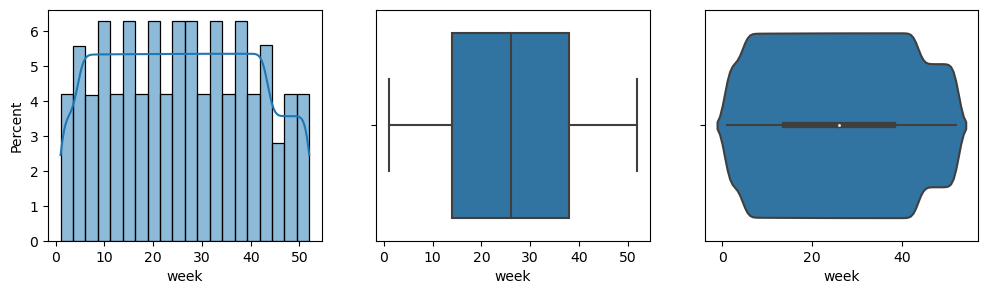

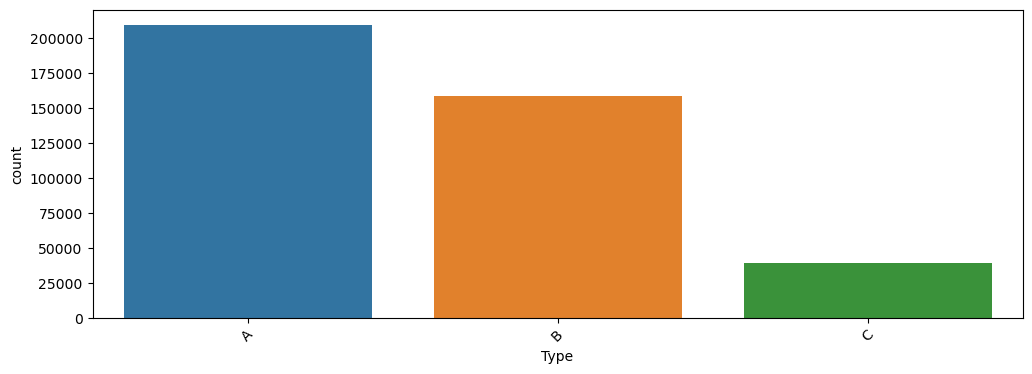

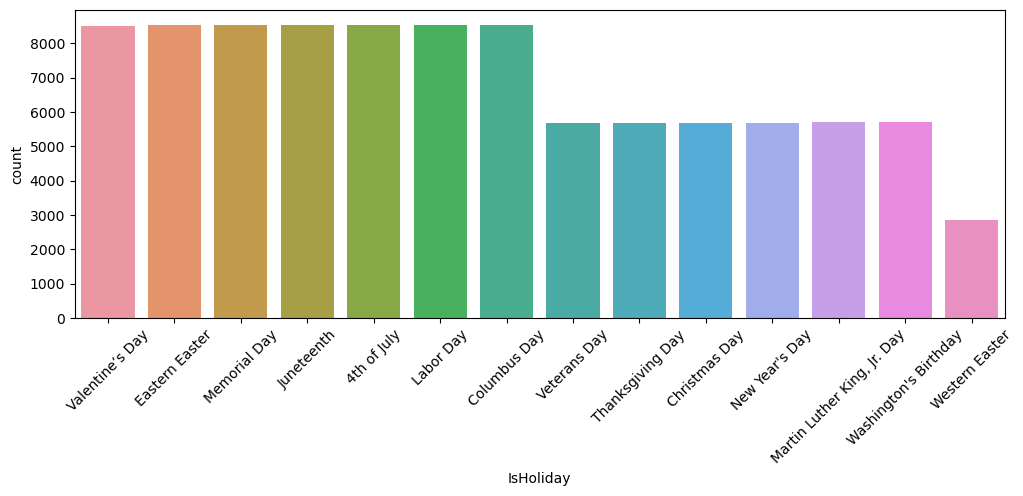

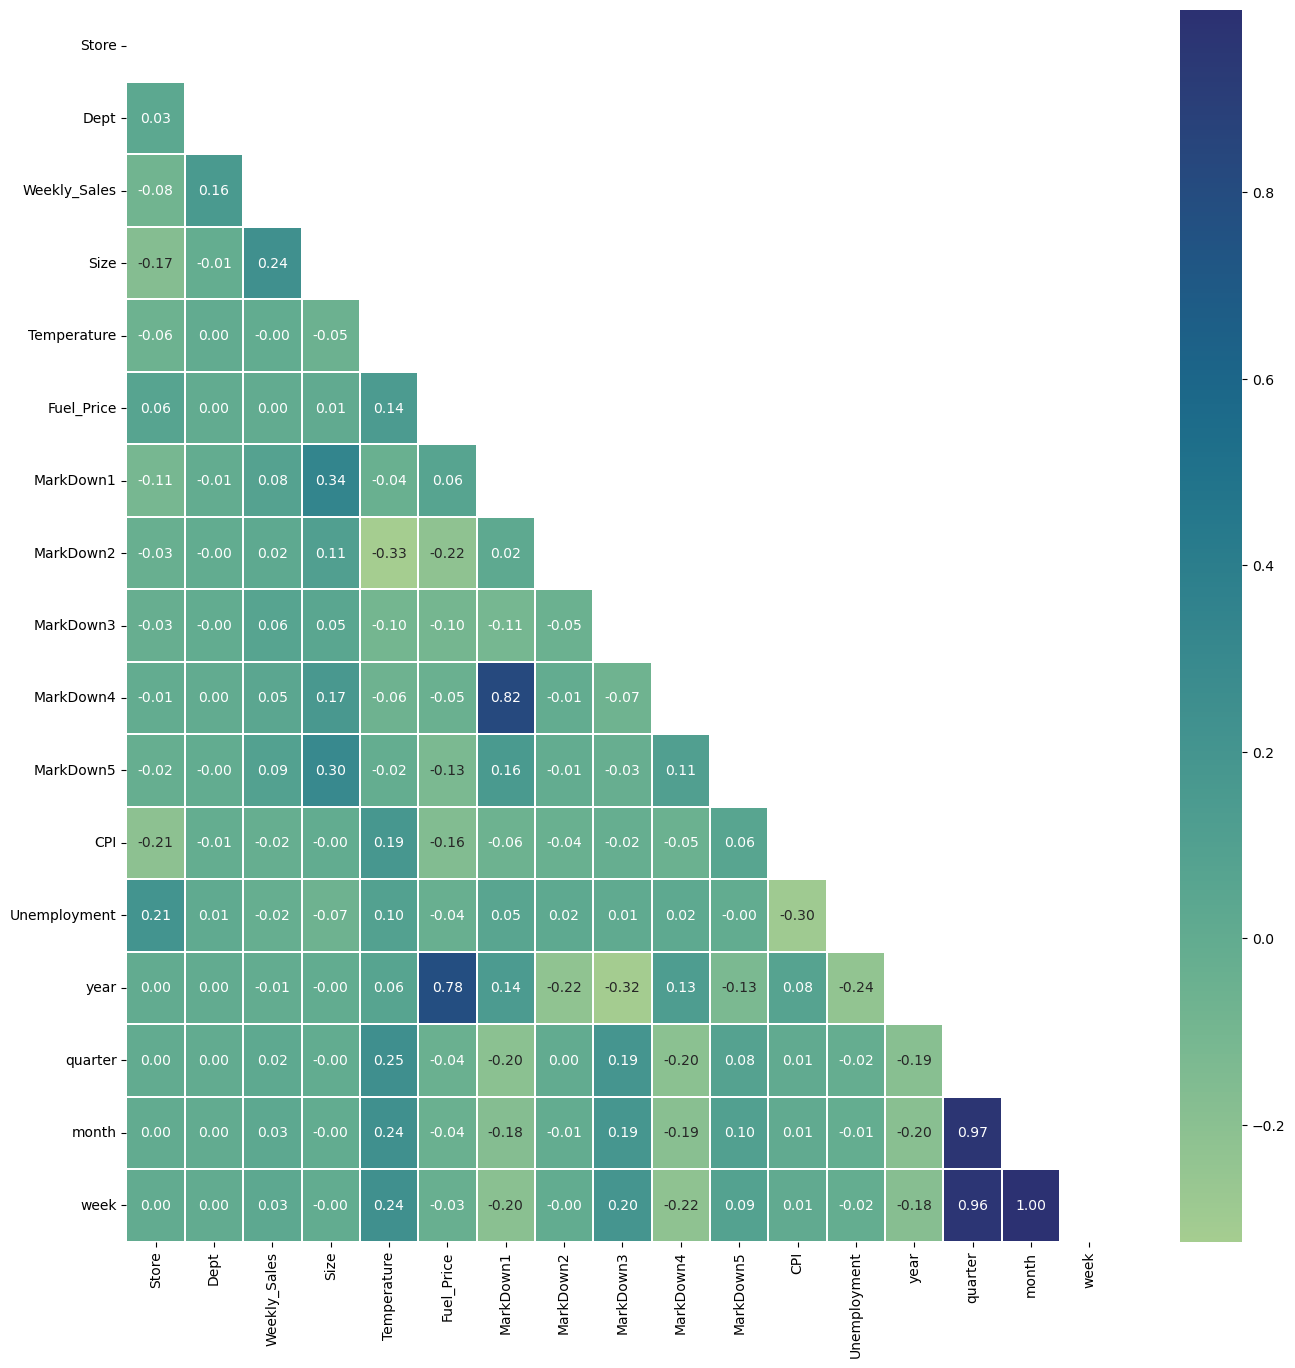

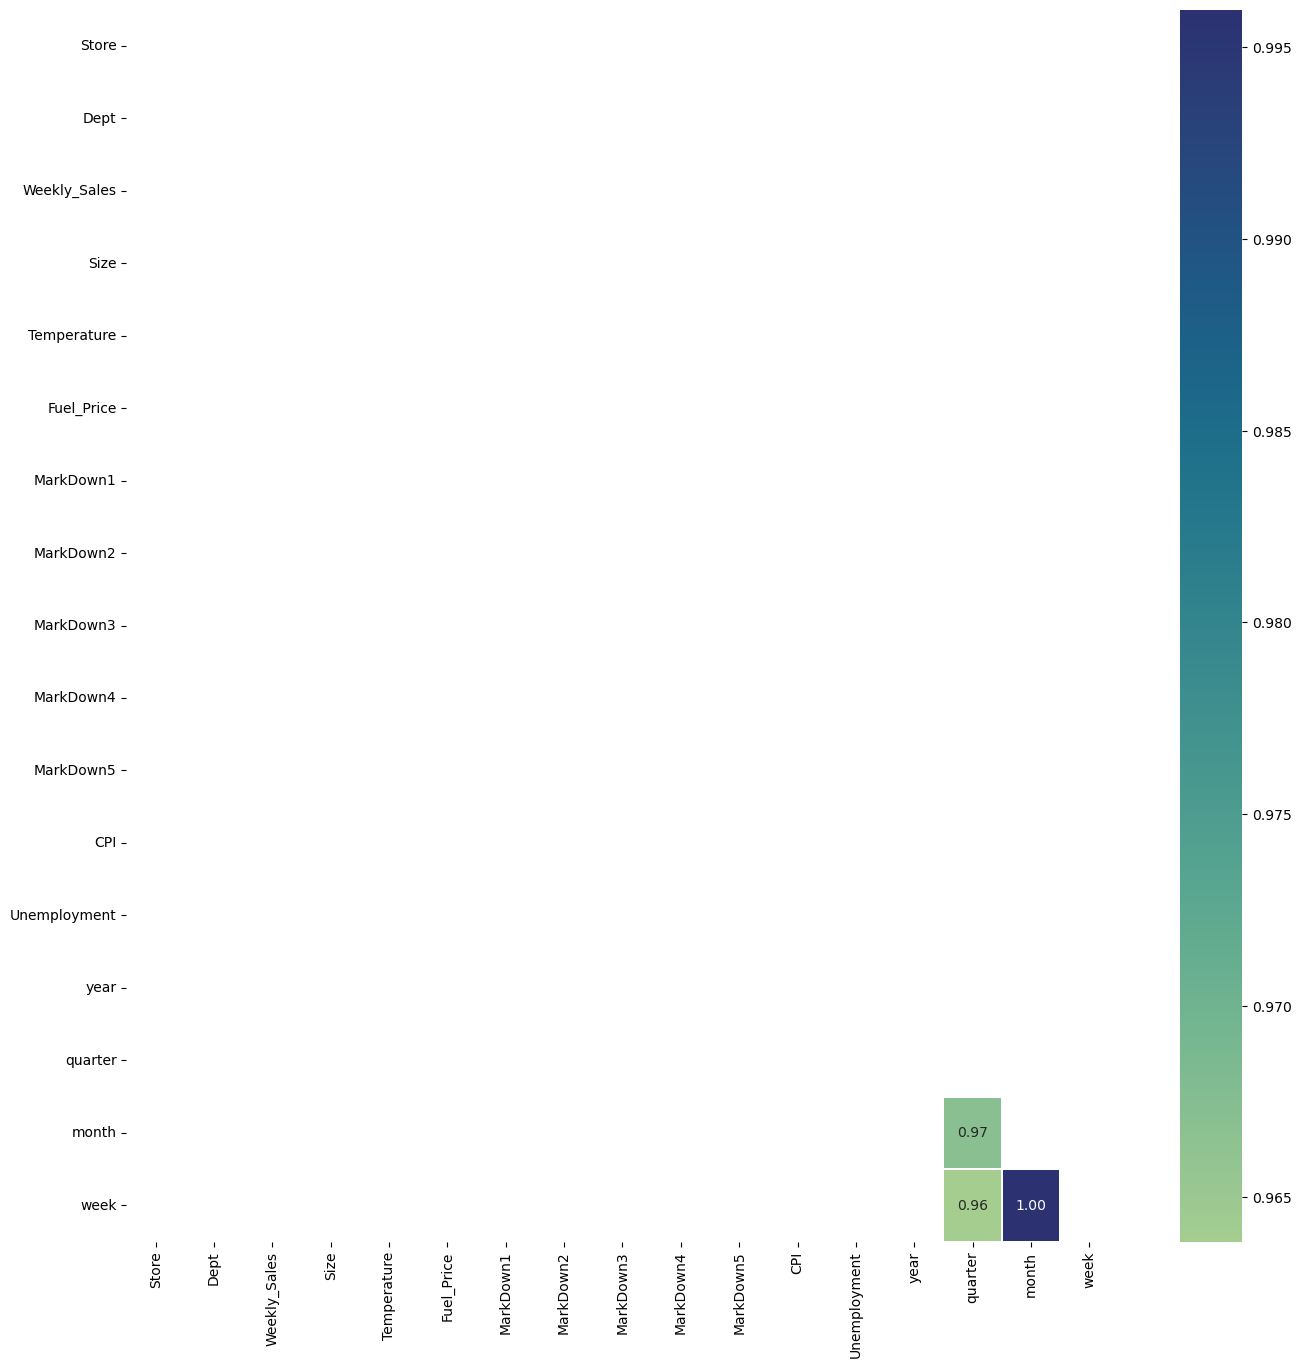

In [30]:
eda.plot_all()

## Findings

#Overall data completion is good

#Skewed distribution: MarkDowns & Weekly Sales

#CPI: No data for 140-180

#Negative & Null values on MarkDowns

#Negative values on Weekly Sales; Return? replaced by zero

#No correlated columns among features; ignore date related columns

# IsHoliday column

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

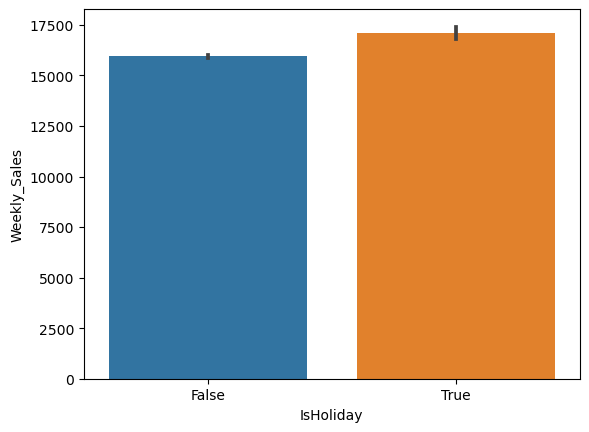

In [31]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [32]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [33]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

The dataset does not include all holidays. There are four holiday types with specific dates:  

- **Super Bowl**: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
- **Labor Day**: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
- **Thanksgiving**: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
- **Christmas**: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13  

After 07-Sep-2012, holidays appear in the test set for prediction. The data shows that average weekly sales during holidays are significantly higher than on non-holiday days. In the training set, there are **133 weeks of non-holiday data** and **10 weeks of holiday data**.  

To analyze the differences between holiday types, I created new boolean columns for each holiday. A value is **True** if the date corresponds to that holiday and **False** otherwise.

In [34]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [35]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [36]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [37]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

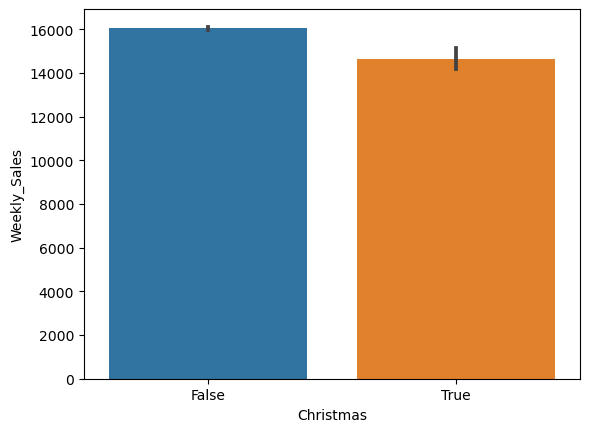

In [38]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

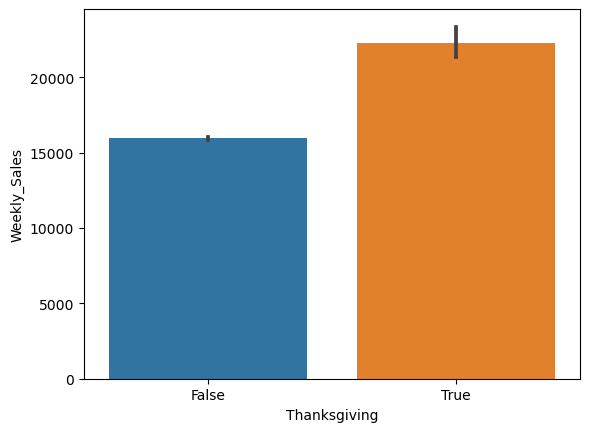

In [39]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

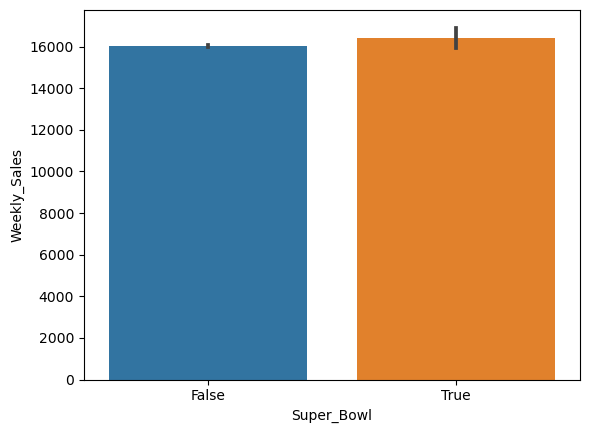

In [40]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

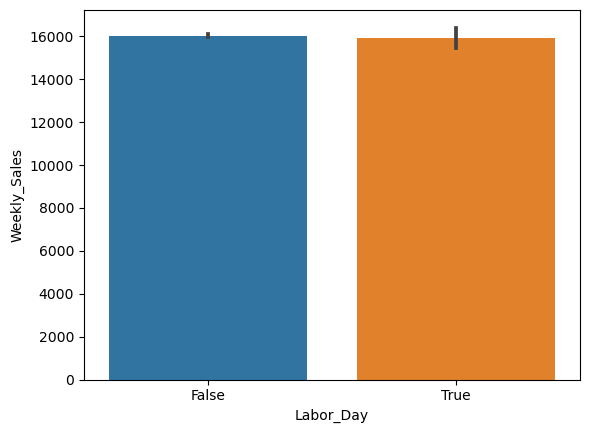

In [41]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

The graphs indicate that Labor Day and Christmas do not lead to an increase in weekly average sales. Sales see a positive impact during the Super Bowl, but the most significant increase occurs during Thanksgiving. This may be because people tend to purchase Christmas gifts 1–2 weeks in advance, resulting in no noticeable change in sales during Christmas week. Additionally, Black Friday sales contribute to the surge in sales during Thanksgiving week.

# Holiday effect on Business

In [42]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [43]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [44]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [45]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

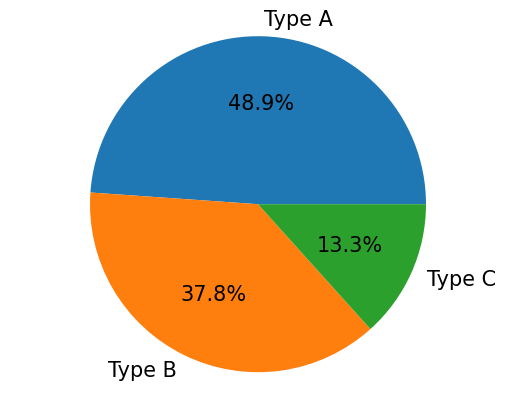

In [46]:
# To see the percentage of stores
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [47]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

Nearly, half of the stores are belongs to Type A.

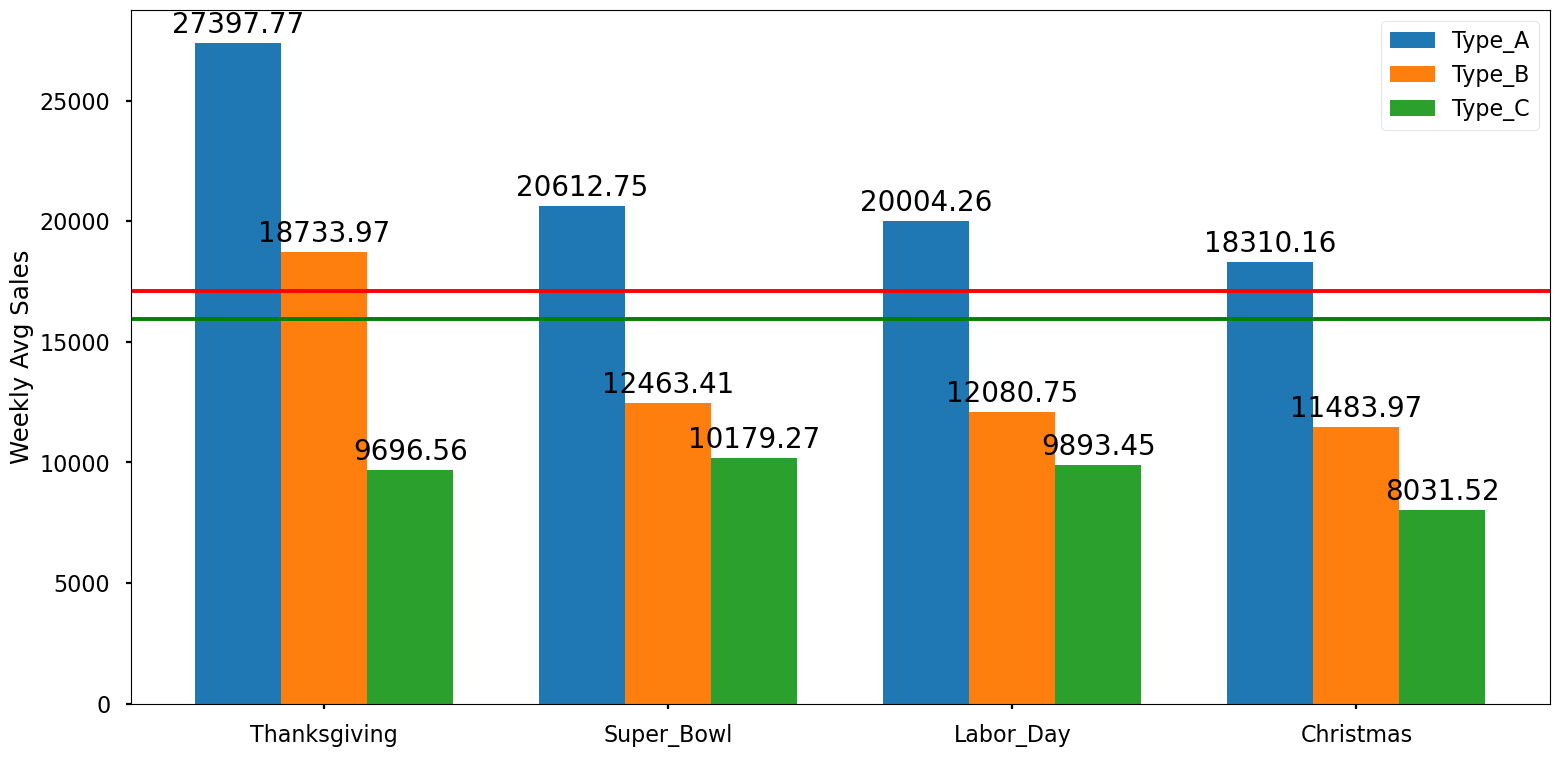

In [48]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

### Weekly Sales by Store, Dept, Type, Size

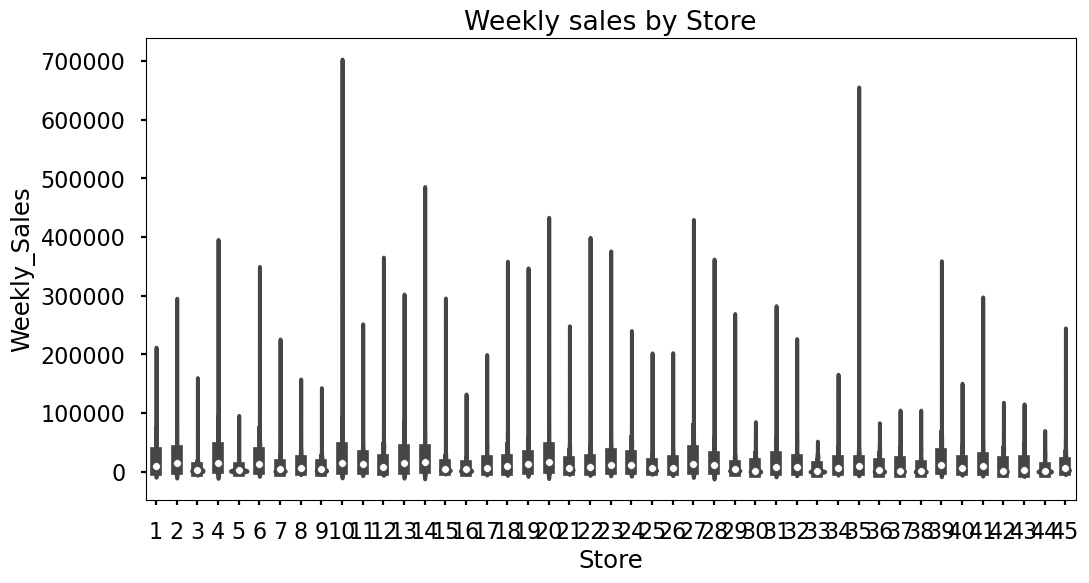

In [49]:
# Weekly sales by Store
plt.figure(figsize=(12,6))
sns.violinplot(data=merged_train_df, x="Store", y="Weekly_Sales")
plt.title("Weekly sales by Store")
plt.show()

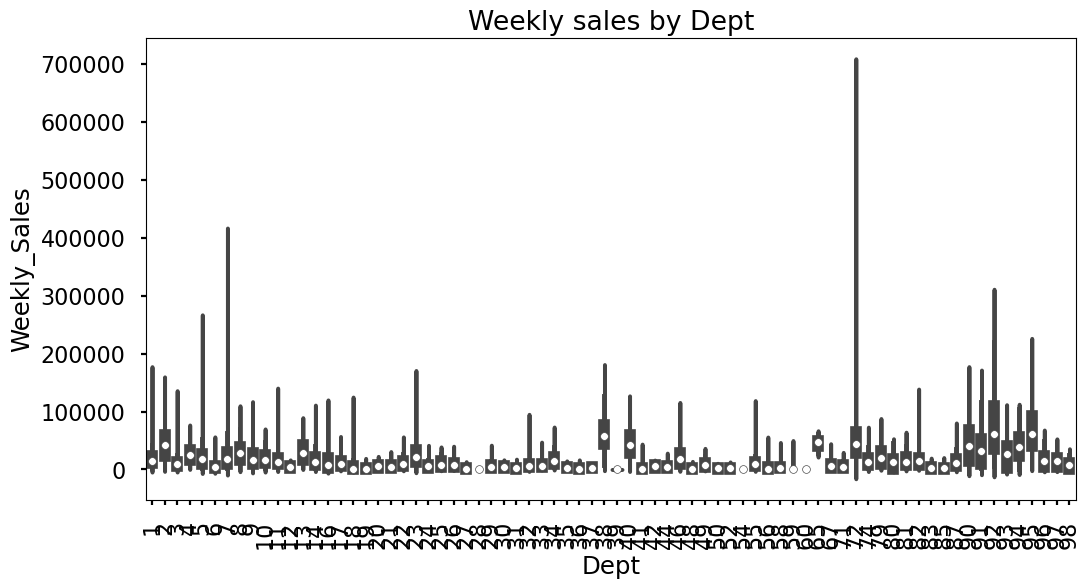

In [50]:
# Weekly sales by Dept
plt.figure(figsize=(12,6))
sns.violinplot(data=merged_train_df, x="Dept", y="Weekly_Sales")
plt.xticks(rotation=90)
plt.title("Weekly sales by Dept")
plt.show()

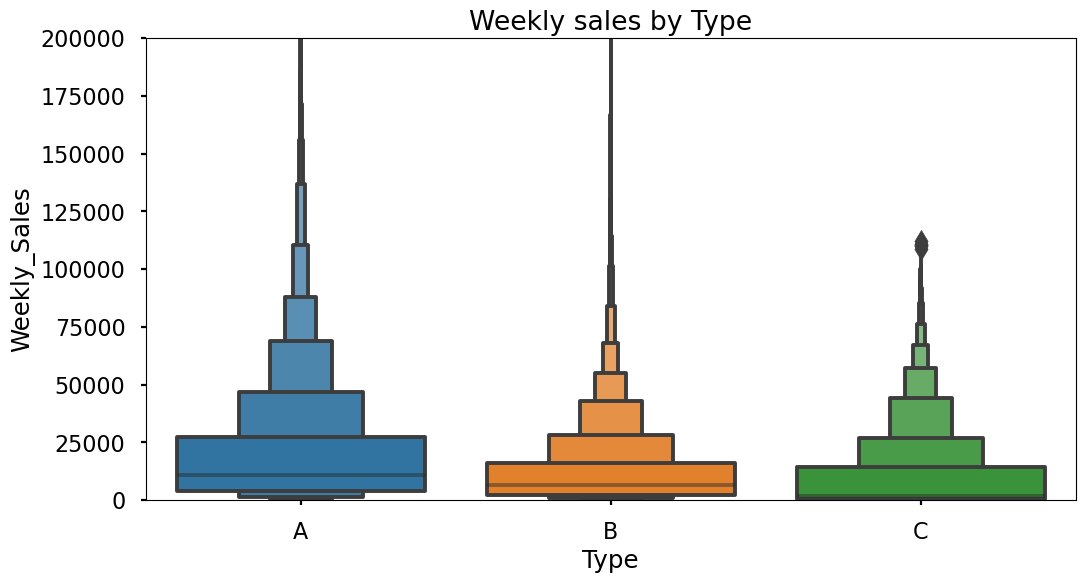

In [51]:
# Weekly sales by Type
plt.figure(figsize=(12,6))
sns.boxenplot(data=merged_train_df, x="Type", y="Weekly_Sales")
plt.ylim([0, 200000])
plt.title("Weekly sales by Type")
plt.show()

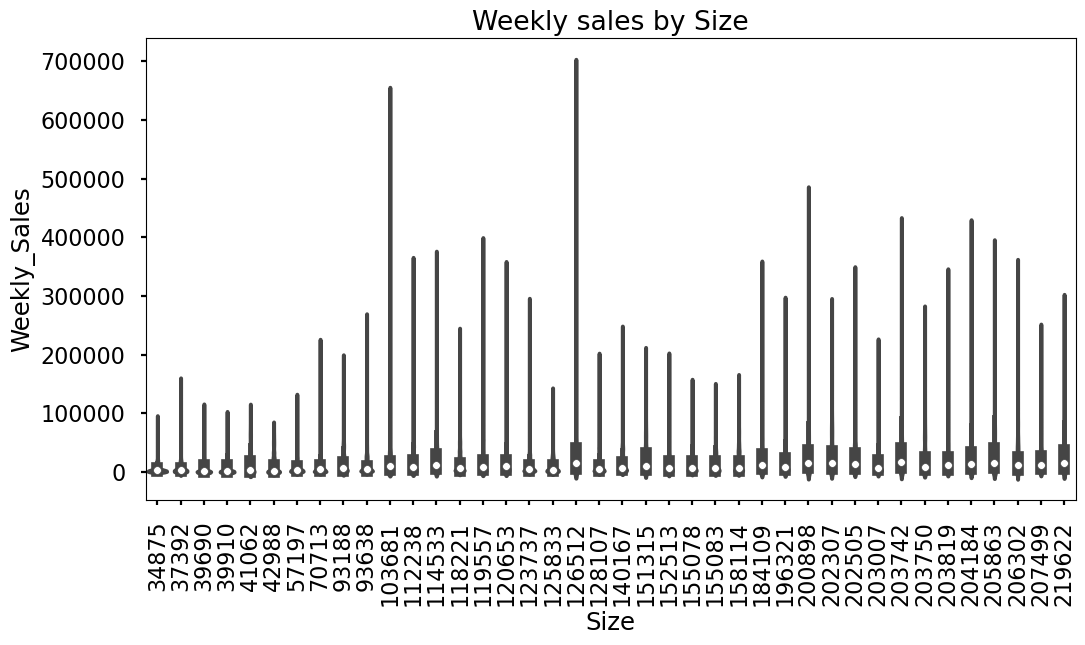

In [52]:
# Weekly sales by Size
plt.figure(figsize=(12,6))
sns.violinplot(data=merged_train_df, x="Size", y="Weekly_Sales")
plt.xticks(rotation=90)
plt.title("Weekly sales by Size")
plt.show()

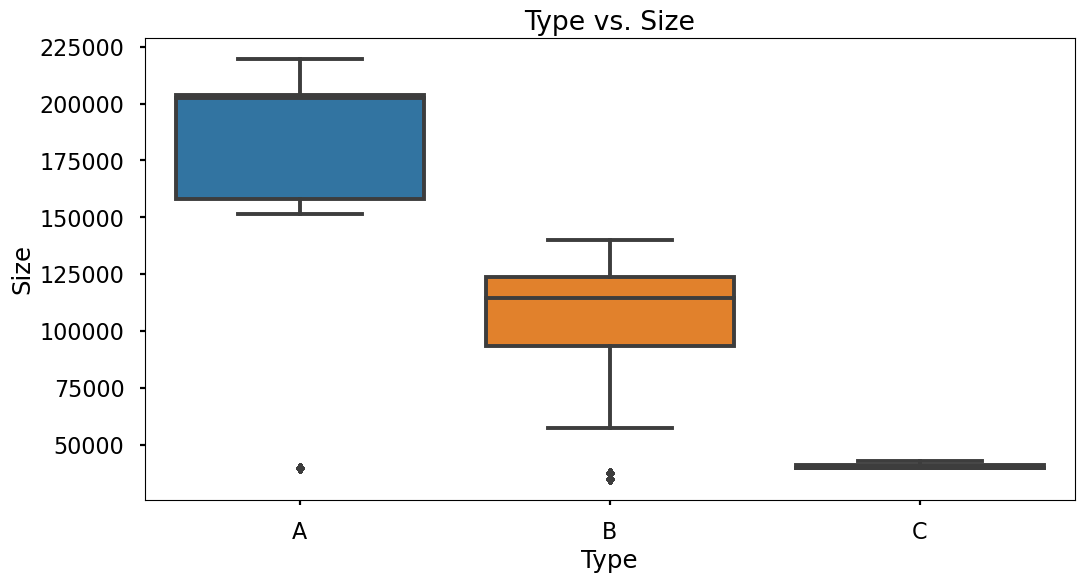

In [53]:
# Type vs. Size?
plt.figure(figsize=(12,6))
sns.boxplot(data=merged_train_df, x="Type", y="Size")
plt.title("Type vs. Size")
plt.show()

#Different weekly sales by store/dept

#Size linked to type; large > A & small > C and larger stores have more weekly sales

# Holiday impact

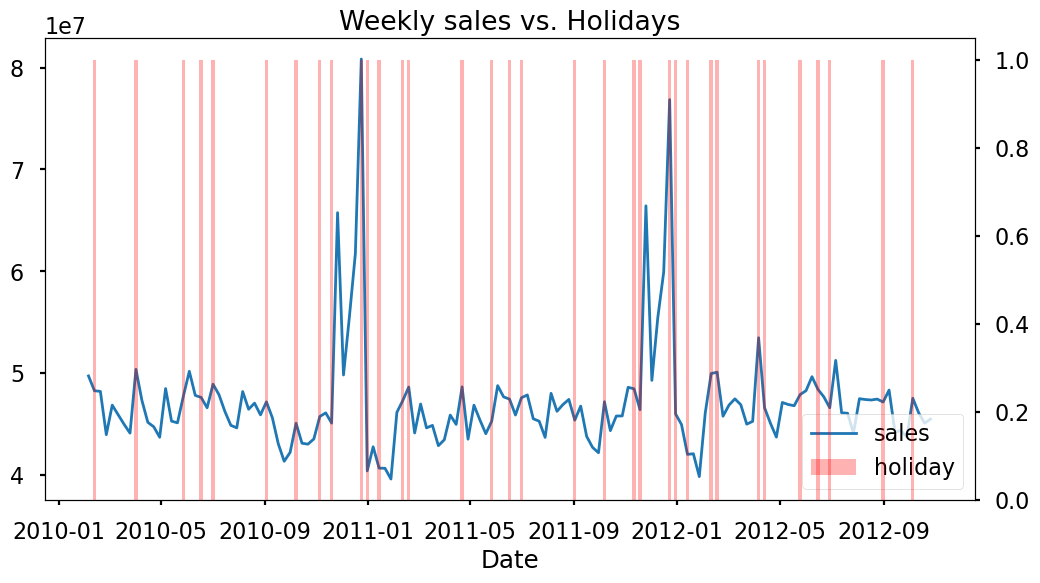

In [54]:
# blue > weekly sales & red > holidays
plot_df = merged_train_df.copy()
plot_df["IsHoliday_int"] = plot_df["IsHoliday"].apply(lambda x: 1 if pd.notnull(x) else 0)
sum_df = plot_df.groupby("Date").agg({"IsHoliday_int": "max", "Weekly_Sales": "sum"}).reset_index()
sum_df

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(sum_df["Date"], sum_df["Weekly_Sales"], linewidth=2, label="sales")
ax2.bar(sum_df["Date"], sum_df["IsHoliday_int"], width=4, color="red", alpha=0.3, label="holiday")
ax1.set_xlabel("Date")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')
plt.title("Weekly sales vs. Holidays")
plt.show()

some holidays picked up sales spike but not all > better to do one-hot encoding with holiday name

# Deeper Look into Sales

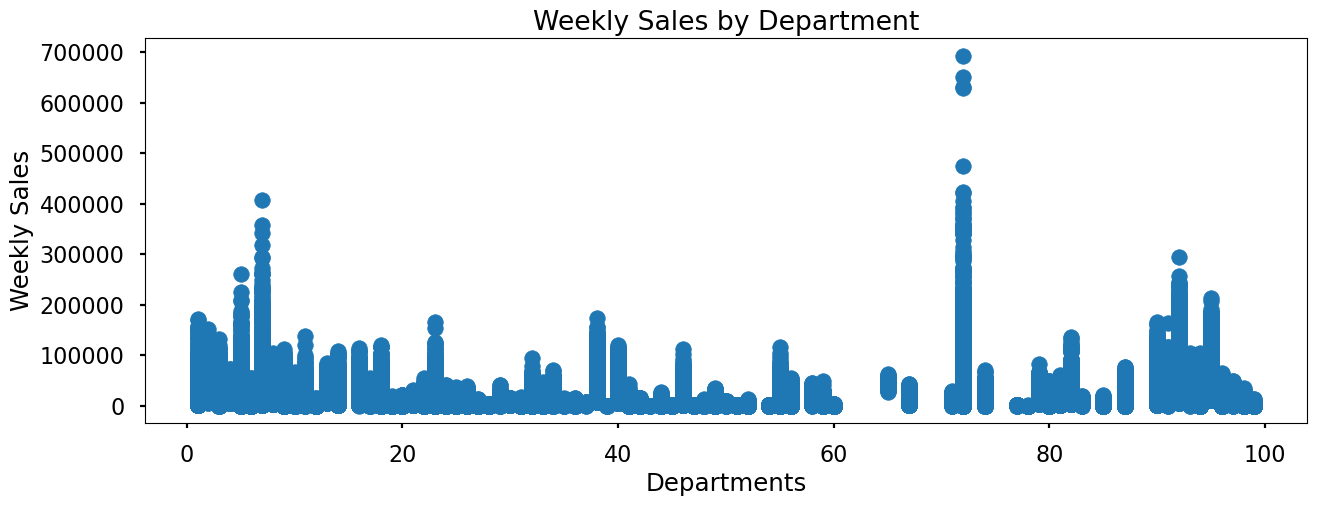

In [55]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

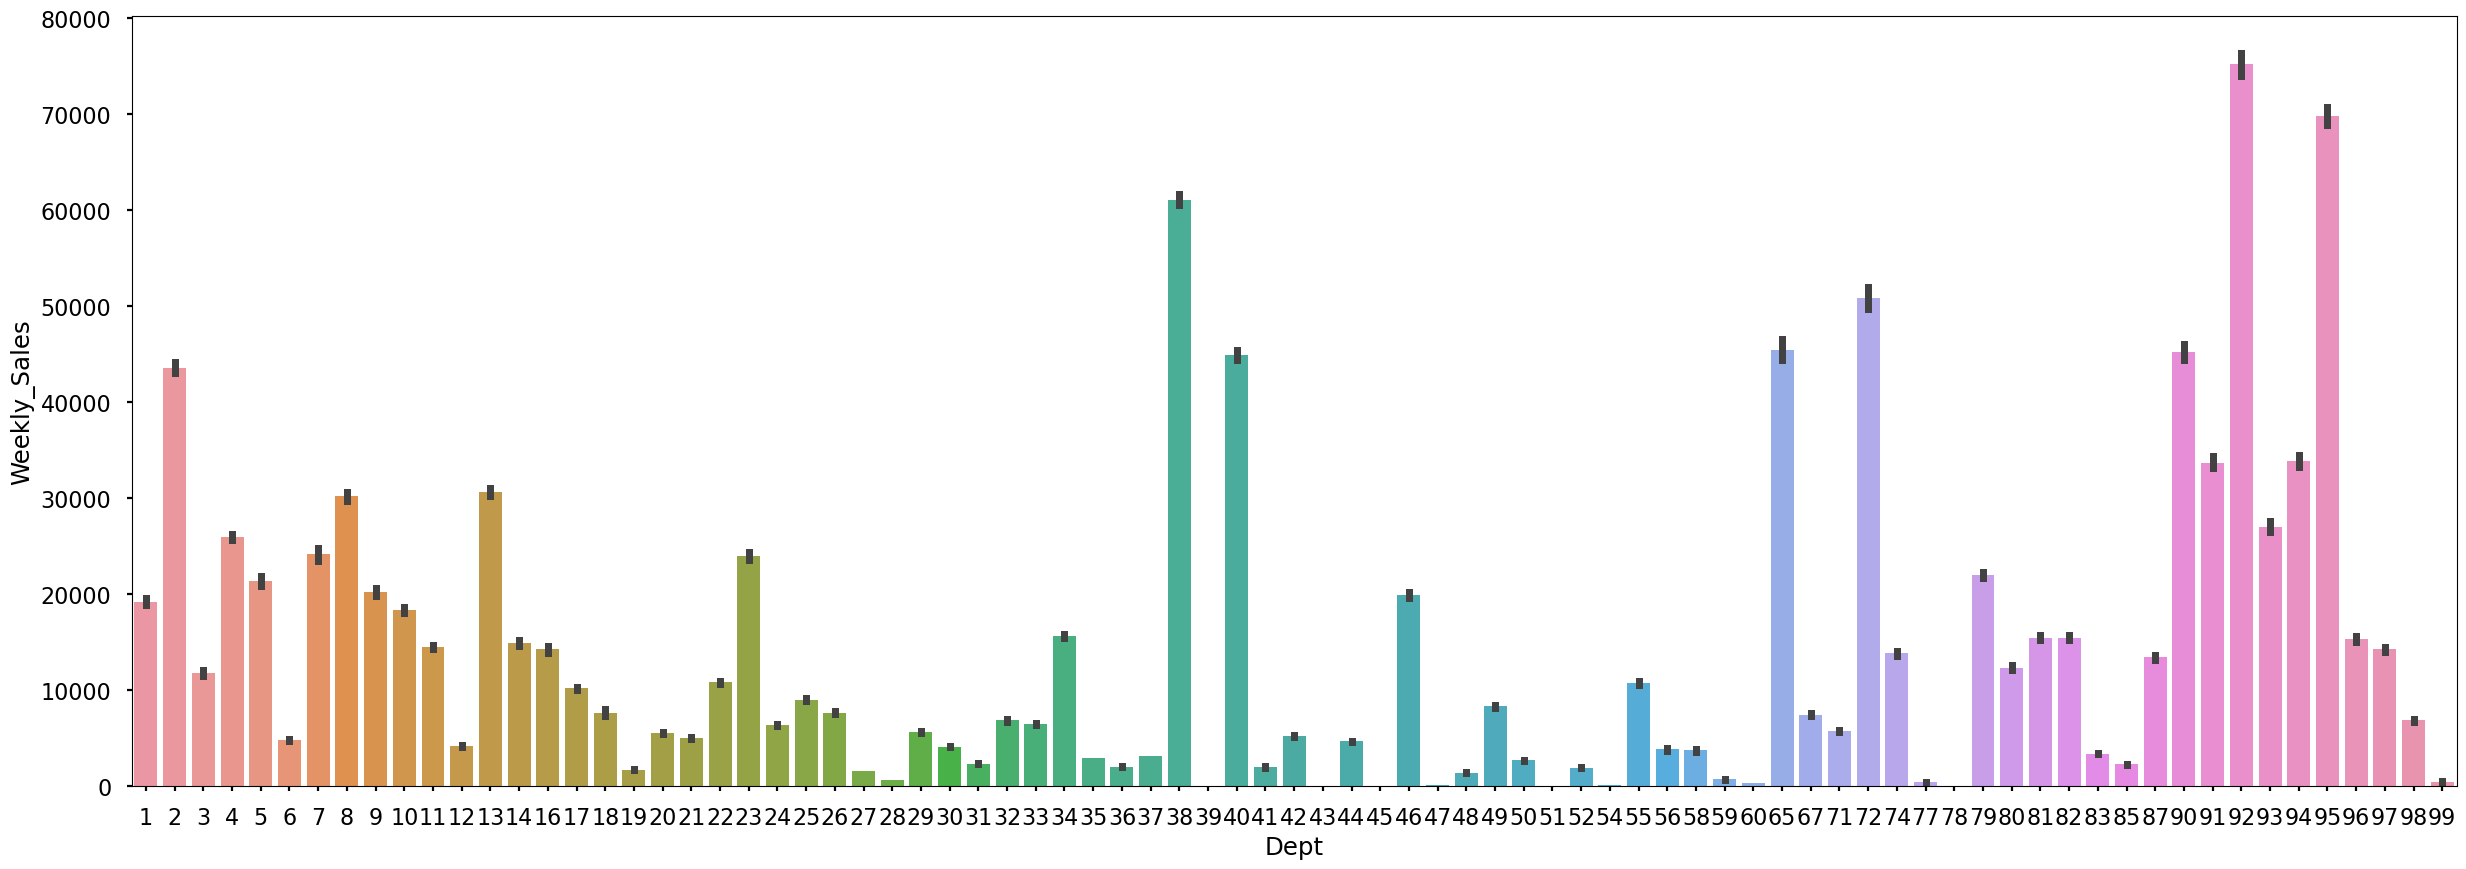

In [56]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

The first graph indicates that a department within the 60-80 range (likely 72) has higher sales values. However, when analyzing the averages, department 92 shows the highest mean sales. This suggests that department 72 is seasonal, experiencing peaks in certain seasons, while department 92 maintains consistently higher average sales.

# Changing Date to Datetime and Creating New Columns

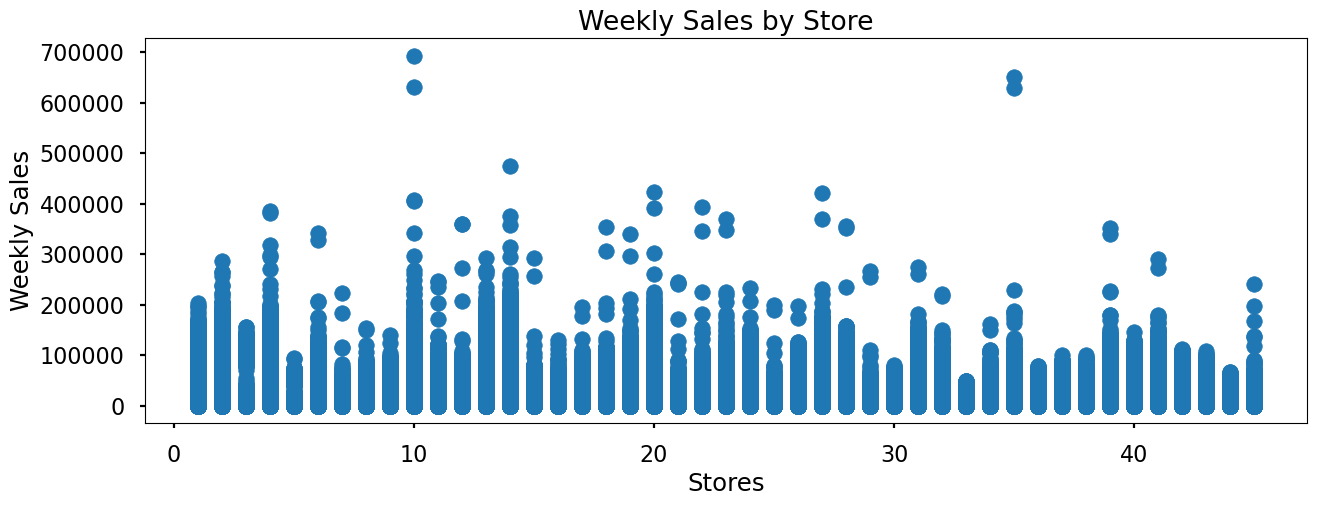

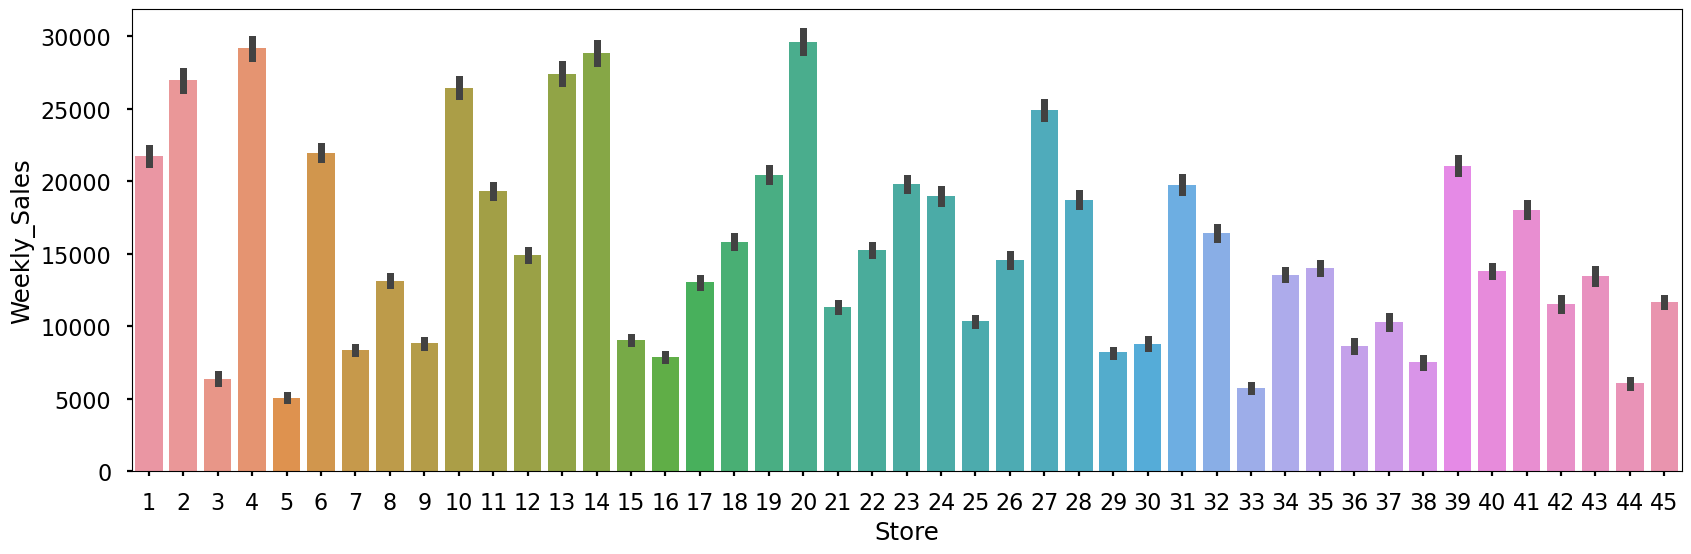

In [57]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)


df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [58]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales


month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [59]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

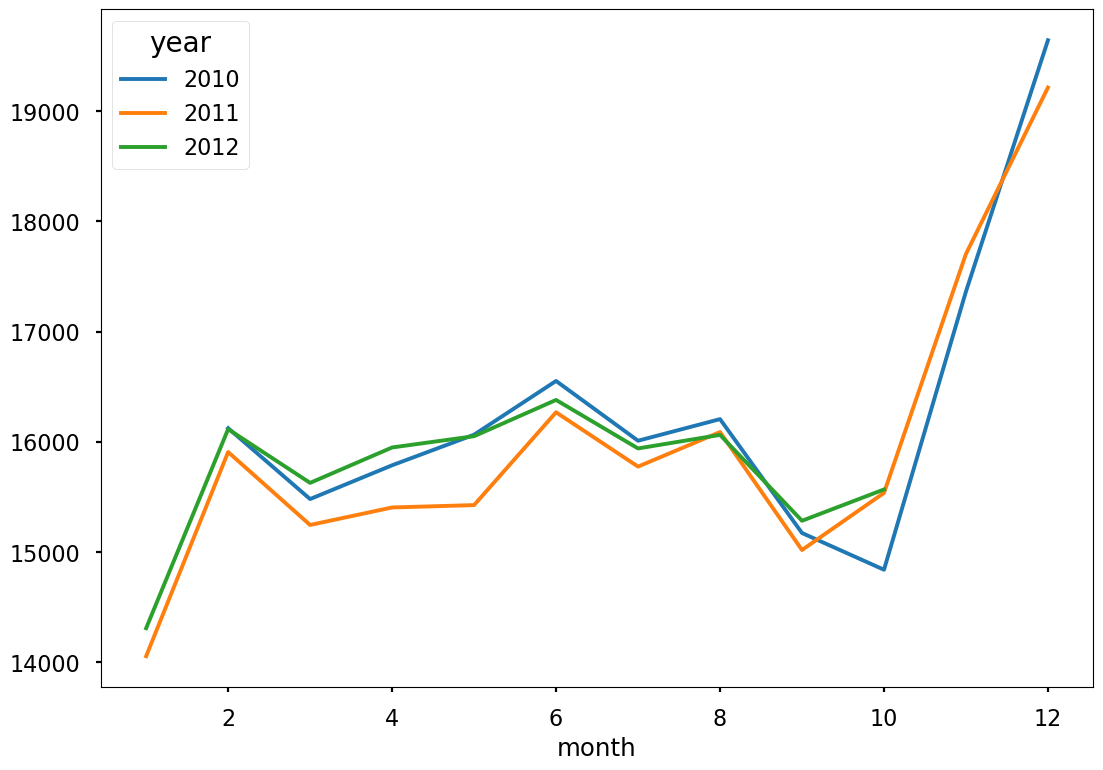

In [60]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

The graph shows that sales in 2011 were generally lower than in 2010. The mean sales for 2010 are higher, but 2012 lacks data for November and December, which typically have higher sales. Despite missing these two months, the mean sales for 2012 are close to those of 2010. If the missing data were included, 2012 would likely take the top position.

# Check others; CPI, Temp, Unemployment & Fuel_price

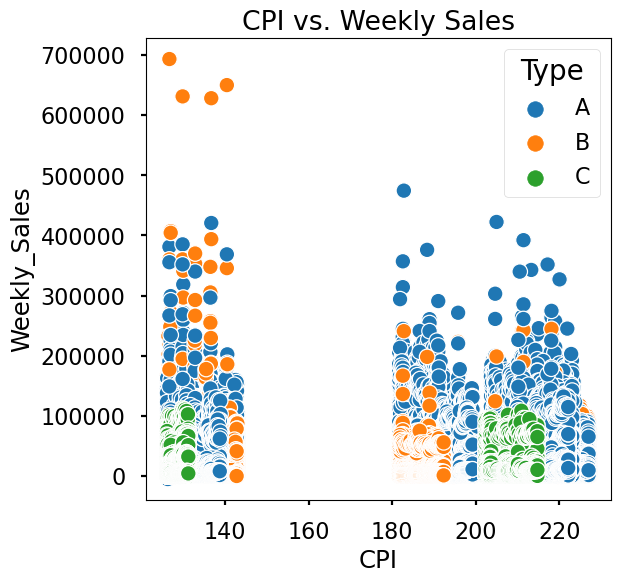

In [61]:
# CPI vs. Weekly Sales
plt.figure(figsize=(6,6))
sns.scatterplot(data=merged_train_df, x="CPI", y="Weekly_Sales", hue="Type")
plt.title("CPI vs. Weekly Sales")
plt.show()

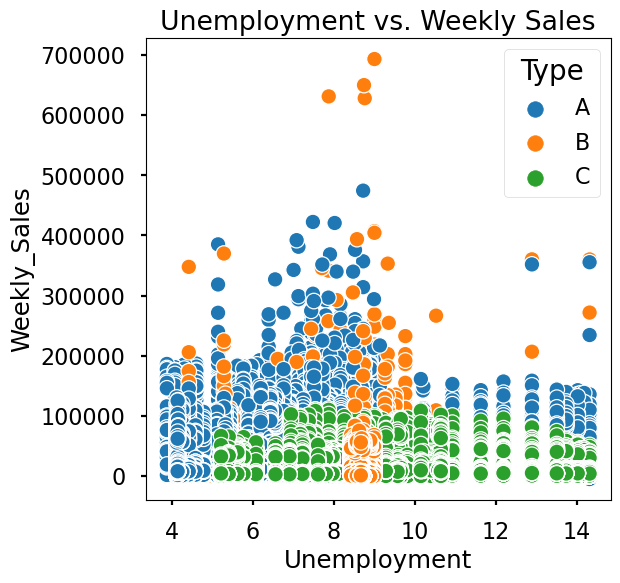

In [62]:
# Unemployment vs. Weekly Sales
plt.figure(figsize=(6,6))
sns.scatterplot(data=merged_train_df, x="Unemployment", y="Weekly_Sales", hue="Type")
plt.title("Unemployment vs. Weekly Sales")
plt.show()

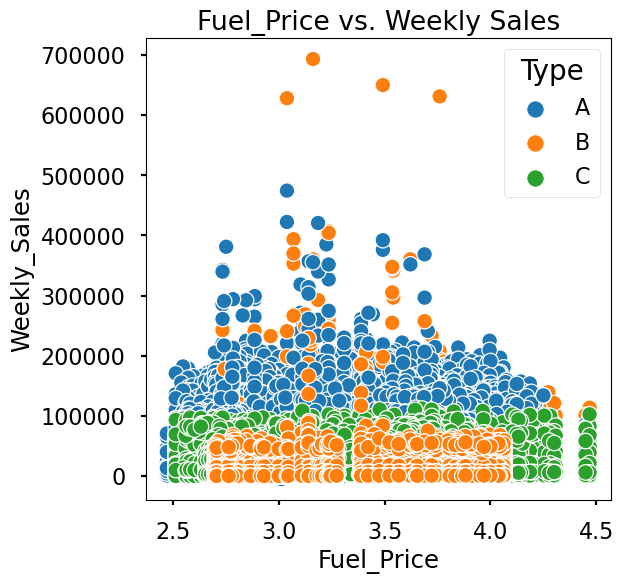

In [63]:
# Fuel_Price vs. Weekly Sales
plt.figure(figsize=(6,6))
sns.scatterplot(data=merged_train_df, x="Fuel_Price", y="Weekly_Sales", hue="Type")
plt.title("Fuel_Price vs. Weekly Sales")
plt.show()

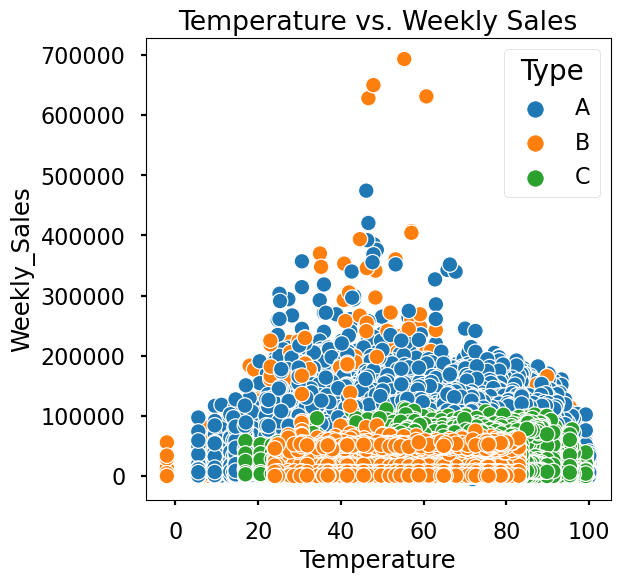

In [64]:
# Temperature vs. Weekly Sales
plt.figure(figsize=(6,6))
sns.scatterplot(data=merged_train_df, x="Temperature", y="Weekly_Sales", hue="Type")
plt.title("Temperature vs. Weekly Sales")
plt.show()

No strong correlations btw Temperature, CPI, Unemployment & Fuel price vs. weekly sales

# Feature Engineering

In [65]:
# check nulls
merged_train_df.isnull().sum()

Date                 0
Store                0
Dept                 0
Weekly_Sales         0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       261961
MarkDown2       299350
MarkDown3       274804
MarkDown4       276216
MarkDown5       261286
CPI                  0
Unemployment         0
year                 0
quarter              0
month                0
week                 0
IsHoliday       310067
dtype: int64

In [66]:
# Store type mapping: A,B,C to 3-2-1 (A larger store & C smaller score based on EDA so this mapping might make sense)
type_group = {'A': 3, 'B': 2, 'C': 1}  # changing A,B,C to 1-2-3
merged_train_df['Type'] = merged_train_df['Type'].replace(type_group)
# merged_test_df['Type'] = merged_test_df['Type'].replace(type_group)

In [67]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for holiday
encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder.fit_transform(merged_train_df[["IsHoliday"]])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(["IsHoliday"]))
merged_train_df = pd.concat([merged_train_df, onehot_encoded_df], axis=1)
merged_train_df = merged_train_df.drop(columns=["IsHoliday", "IsHoliday_nan"], axis=1)

# fill in 0 for null values and negative values
mrkdw_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "Weekly_Sales"]
merged_train_df[mrkdw_cols] = merged_train_df[mrkdw_cols].where(merged_train_df[mrkdw_cols]>=0, 0)

import pandas as pd
from typing import Union, List
from itertools import product
from scipy.stats import zscore, median_abs_deviation, iqr
from sklearn.cluster import KMeans, MeanShift, Birch
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer


def feature_substract_columns(df: pd.DataFrame, base_col: str, sub_col: str, new_col: str, neg_zero: bool = False) -> pd.DataFrame:
    df[new_col] = df[base_col] - df[sub_col]

    if neg_zero:
        df[new_col] = df[new_col].clip(lower=0)

    return df

def feature_count_words(df: pd.DataFrame, col: str, new_col: str, delimiter: str) -> pd.DataFrame:
    df[new_col] = [len(x.split(delimiter)) for x in df[col].tolist()]

    return df

def feature_label_encode(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    le = LabelEncoder()
    df[cols] = le.fit_transform(df[cols])

    return df, le

def feature_multiply_columns(df: pd.DataFrame, base_col: str, mul_col: str, new_col:str, decimeter: int) -> pd.DataFrame:
    df[new_col] = df[base_col] * df[mul_col]

    if decimeter is not None:
        df[new_col] = df[new_col] / decimeter

    return df

def feature_devide_columns(df: pd.DataFrame, base_col: str, dev_col: str, new_col:str, decimeter: int = None) -> pd.DataFrame:
    df[new_col] = df[base_col] / df[dev_col]

    if decimeter is not None:
        df[new_col] = df[new_col] * decimeter

    return df

def feature_lag_values(df: pd.DataFrame, sort_col: str, col: str, lag: list, grp_col: Union[str, List] = None, impute_method: str = "zeros") -> pd.DataFrame:
    if grp_col:
        for n in lag:
            df[f"{col}_lag{n}"] = df.sort_values(by=sort_col).groupby(grp_col)[col].shift(n)
    else:
        for n in lag:
            df[f"{col}_lag{n}"] = df.sort_values(by=sort_col)[col].shift(n)
    
    if impute_method == "zeros":
        for n in lag:
            df[f"{col}_lag{n}"] = df[f"{col}_lag{n}"].fillna(0)
    else:
        for n in lag:
            df[f"{col}_lag{n}"] = df[f"{col}_lag{n}"].fillna(np.NaN)

    return df

In [68]:
# Generate lags features
sort_col = "Date"
grp_col = ["Store", "Dept"]
cols = ["Weekly_Sales"]
lags = [1,2]

for col in cols:
    merged_train_df = feature_lag_values(merged_train_df, sort_col, col, lags, grp_col)
    # df = feature_hist_agg_values(df, sort_col, col, lags, func, grp_col)

merged_train_df

,Date,Store,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,"IsHoliday_Martin Luther King, Jr. Day",IsHoliday_Memorial Day,IsHoliday_New Year's Day,IsHoliday_Thanksgiving Day,IsHoliday_Valentine’s Day,IsHoliday_Veterans Day,IsHoliday_Washington's Birthday,IsHoliday_Western Easter,Weekly_Sales_lag1,Weekly_Sales_lag2
0,2010-02-05,1,1,24924.50,3,151315,42.31,2.572,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
1,2010-02-12,1,1,46039.49,3,151315,38.51,2.548,0.00,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24924.50,0.00
2,2010-02-19,1,1,41595.55,3,151315,39.93,2.514,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46039.49,24924.50
3,2010-02-26,1,1,19403.54,3,151315,46.63,2.561,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41595.55,46039.49
4,2010-03-05,1,1,21827.90,3,151315,46.50,2.625,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19403.54,41595.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406814,2012-09-28,45,98,508.37,2,118221,64.88,3.997,4556.61,20.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,467.30,605.96
406815,2012-10-05,45,98,628.10,2,118221,64.89,3.985,5046.74,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,508.37,467.30
406816,2012-10-12,45,98,1061.02,2,118221,54.47,4.000,1956.28,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,628.10,508.37
406817,2012-10-19,45,98,760.01,2,118221,56.47,3.969,2004.02,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1061.02,628.10


In [69]:
# Final check
merged_train_df.isnull().sum()

Date                                     0
Store                                    0
Dept                                     0
Weekly_Sales                             0
Type                                     0
Size                                     0
Temperature                              0
Fuel_Price                               0
MarkDown1                                0
MarkDown2                                0
MarkDown3                                0
MarkDown4                                0
MarkDown5                                0
CPI                                      0
Unemployment                             0
year                                     0
quarter                                  0
month                                    0
week                                     0
IsHoliday_4th of July                    0
IsHoliday_Christmas Day                  0
IsHoliday_Columbus Day                   0
IsHoliday_Eastern Easter                 0
IsHoliday_J

# Modelling: Hyper param tuning & Evaluation

## Defining models - TS regression

1) SARIMA (sep model)  
2) Elastic Net (all)  
3) RF (all)  
4) LGBM (all)  
5) LSTM/AR LSTM (sep model)  
6) GRU (sep model)  

In [70]:
import re

# modify column names to avoid error due to column name
merged_train_df = merged_train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
merged_train_df.columns

Index(['Date', 'Store', 'Dept', 'Weekly_Sales', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'year', 'quarter', 'month', 'week',
       'IsHoliday_4thofJuly', 'IsHoliday_ChristmasDay',
       'IsHoliday_ColumbusDay', 'IsHoliday_EasternEaster',
       'IsHoliday_Juneteenth', 'IsHoliday_LaborDay',
       'IsHoliday_MartinLutherKingJrDay', 'IsHoliday_MemorialDay',
       'IsHoliday_NewYearsDay', 'IsHoliday_ThanksgivingDay',
       'IsHoliday_ValentinesDay', 'IsHoliday_VeteransDay',
       'IsHoliday_WashingtonsBirthday', 'IsHoliday_WesternEaster',
       'Weekly_Sales_lag1', 'Weekly_Sales_lag2'],
      dtype='object')

In [71]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 2, gap=0)
train_cut_date = "2012-10-01"
max_lags  = 2
df = merged_train_df.copy()

df.set_index("Date", inplace=True)
df.sort_index(inplace=True)
# base date > data will be split
base_date = min(df.index) + pd.Timedelta(weeks=max_lags)
print(base_date)
df = df[base_date:]

# train-test data split based on base date
tr_df = df[:train_cut_date]
te_df = df[train_cut_date:]

tgt_col = "Weekly_Sales"
X_train = tr_df.drop(columns=tgt_col, axis=1)
y_train = tr_df[tgt_col]

X_test = te_df.drop(columns=tgt_col, axis=1)
y_test = te_df[tgt_col]

2010-02-19 00:00:00


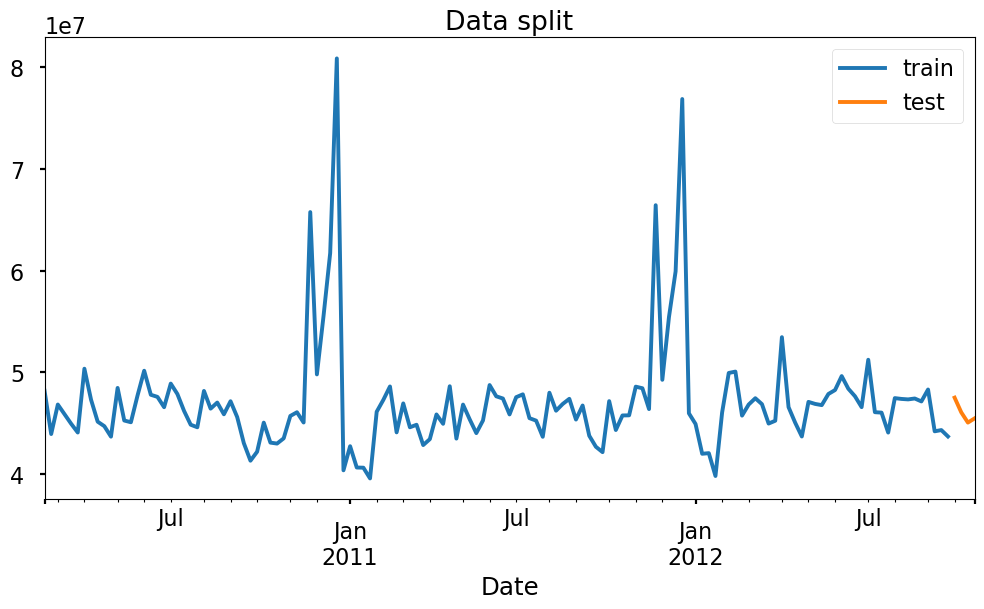

In [72]:
# Display data split
plt.figure(figsize=(12,6))
y_train.groupby("Date").sum().plot(label="train")
y_test.groupby("Date").sum().plot(label="test")
plt.legend()
plt.title("Data split")
plt.show()

In [73]:
# store each model evaluation and data frames
best_models = {}
output_all_tr_dict = {}
output_all_pred_dict = {}

# 1) SARIMA

Model will be implemented for Store & Dept combination but it takes too much time to find params for each model.
Approach will be general params will be defined with weekly aggregated data and apply it to each combination.

In [74]:
!pip install pmdarima


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [75]:
# Define ARIMA params with aggregated data
from pmdarima import auto_arima

df_arima = tr_df.copy()

data = df_arima.groupby("Date")["Weekly_Sales"].sum()
model = auto_arima(data, seasonal=False, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4657.359, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5233.527, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5145.611, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4655.136, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5119.723, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4632.893, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4636.569, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4631.756, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4645.937, Time=0.00 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  137
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -2311.874
Date:                Fri, 28 Mar 2025   AIC                           4631.749
Time:                        21:03:24   BIC                           4643.428
Sample:                    02-19-2010   HQIC                          4636.495
                         - 09-28-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.743e+07   9.68e-10   2.83e+16      0.000    2.74e+07    2.74e+07
ar.L1          0.2946      0.050      5.886      0.000       0.197       0.393
ar.L2          0.1224      0.054      2.259      0.024       0.016       0.229
sigma2      2.687e+13   9.28e-16    2.9e+28      0.000    2.69e+13    2.69e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1037.56
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             2.52
Prob(H) (two-sided):                  0.51   Kurtosis:                        15.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+44. Standard errors may be unstable.
"""

In [76]:
import time
import pandas as pd
from pmdarima import auto_arima
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Get unique store-dept combinations for imputation
combinations = df_arima[["Store", "Dept"]].drop_duplicates()
combinations

# for calculate executed time
train_time = 0
test_time = 0

# Define the function to fit ARIMA for each store-dept combination
def fit_predict_arima(store_id, dept, data, seasonal_period=4):

    # Filter data for the specific store-dept combination
    df = data[(data["Store"] == store_id) & (data["Dept"] == dept)]
    
    # Define the target variable
    y = df["Weekly_Sales"] 
    y.index = pd.DatetimeIndex(y.index.values, freq="W-FRI")
    
    # Fit the ARIMA w/o seasonality orders
    start_time = time.time()
    model = SARIMAX(endog=y, order=(2,0,0), seasonal_order=(0,0,0,0)).fit(disp=False)
    end_time = time.time()
    train_time = end_time - start_time

    # store train prediction to dataframe
    fcst_train_df = pd.DataFrame({
        "Date": df.index,
        "Store": store_id,
        "Dept": dept,
        "Weekly_Sales": df["Weekly_Sales"],
        "Weekly_Sales_pred": model.predict()
    })
    start_time = time.time()
    forecast = model.forecast(4)  # Forecast 4 weeks ahead
    end_time = time.time()
    test_time = end_time - start_time

    # Generate future dates for the forecast period
    last_date = df_arima.index.max()
    forecast_dates = pd.date_range(start=last_date, periods=4+1, freq='W-FRI')[1:]

    # Create a DataFrame for the forecast results
    forecast_df = pd.DataFrame({
        "Date": forecast_dates,
        "Store": store_id,
        "Dept": dept,
        "Weekly_Sales_pred": forecast,
    })
 
    # Return the outputs
    return fcst_train_df, forecast_df, train_time, test_time

start_time = time.time()

# List to store forecast DataFrames for each combination
forecast_results = []
forecast_train_results = []

# Iterate through each store-dept combination and fit ARIMA
for _, row in combinations.iterrows():
    store_id = row['Store']
    dept = row['Dept']
    forecast_train_df, forecast_df, tr_time, tst_time = fit_predict_arima(store_id, dept, df_arima)
    forecast_train_results.append(forecast_train_df)
    forecast_results.append(forecast_df)
    train_time += tr_time
    test_time += tst_time
end_time = time.time()

print("Execution time: %s seconds" %(end_time - start_time))

# Combine all forecast results into a single DataFrame
final_forecast_train_df = pd.concat(forecast_train_results, ignore_index=True)
final_forecast_df = pd.concat(forecast_results, ignore_index=True)

final_forecast_train_df["Weekly_Sales_pred"] = final_forecast_train_df["Weekly_Sales_pred"].apply(lambda x: x if x>=0 else 0)
final_forecast_df["Weekly_Sales_pred"] = final_forecast_df["Weekly_Sales_pred"].apply(lambda x: x if x>=0 else 0)

# Print or save the forecast data
print(final_forecast_train_df)
print(final_forecast_df)
print("train time =", train_time, "test time =", test_time)

Execution time: 28.956186294555664 seconds
             Date  Store  Dept  Weekly_Sales  Weekly_Sales_pred
0      2010-02-19      6    95      79921.51           0.000000
1      2010-02-26      6    95      77582.92       79530.353490
2      2010-03-05      6    95      84641.44       78219.706639
3      2010-03-12      6    95      85516.83       81742.587980
4      2010-03-19      6    95     101969.74       84927.451902
...           ...    ...   ...           ...                ...
389795 2012-08-31     19    39          4.47           0.000000
389796 2012-09-07     19    39         13.41           3.698619
389797 2012-09-14     19    39         20.86          17.500226
389798 2012-09-21     19    39         20.86          20.981741
389799 2012-09-28     19    39         11.92          13.780781

[389800 rows x 5 columns]
            Date  Store  Dept  Weekly_Sales_pred
0     2012-10-05      6    95       82502.667002
1     2012-10-12      6    95       81672.023007
2     2012-10-1

## Pivot tables

<Axes: xlabel='week'>

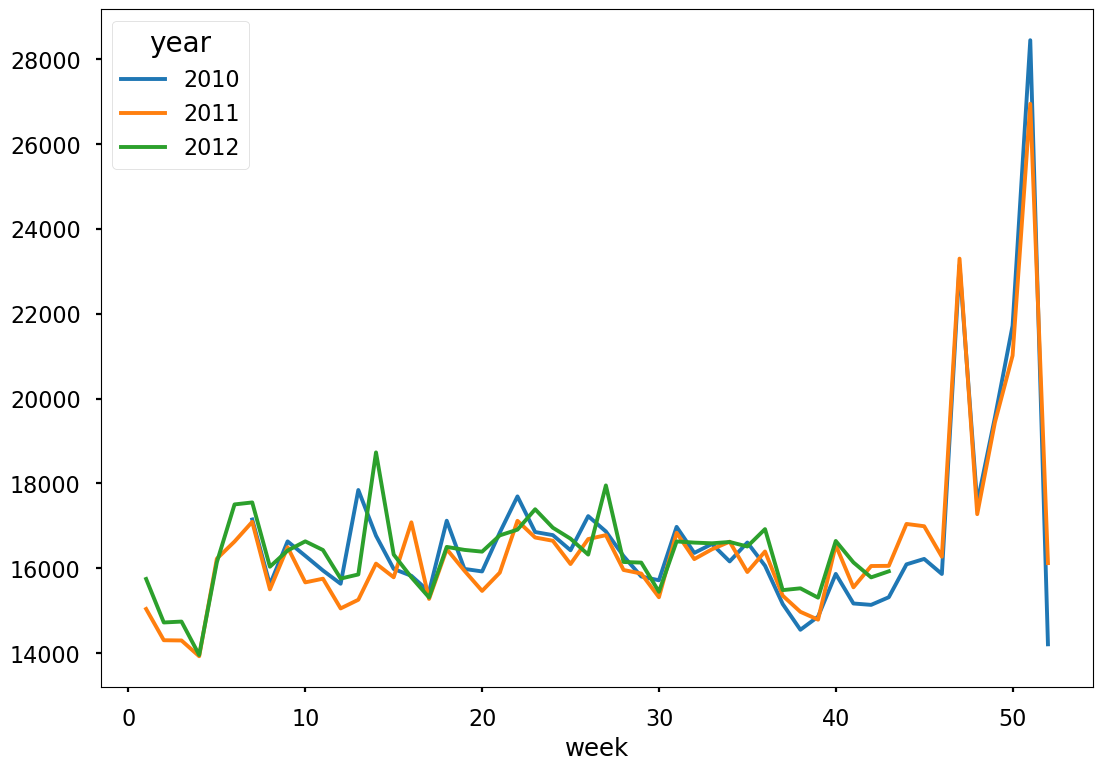

In [77]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

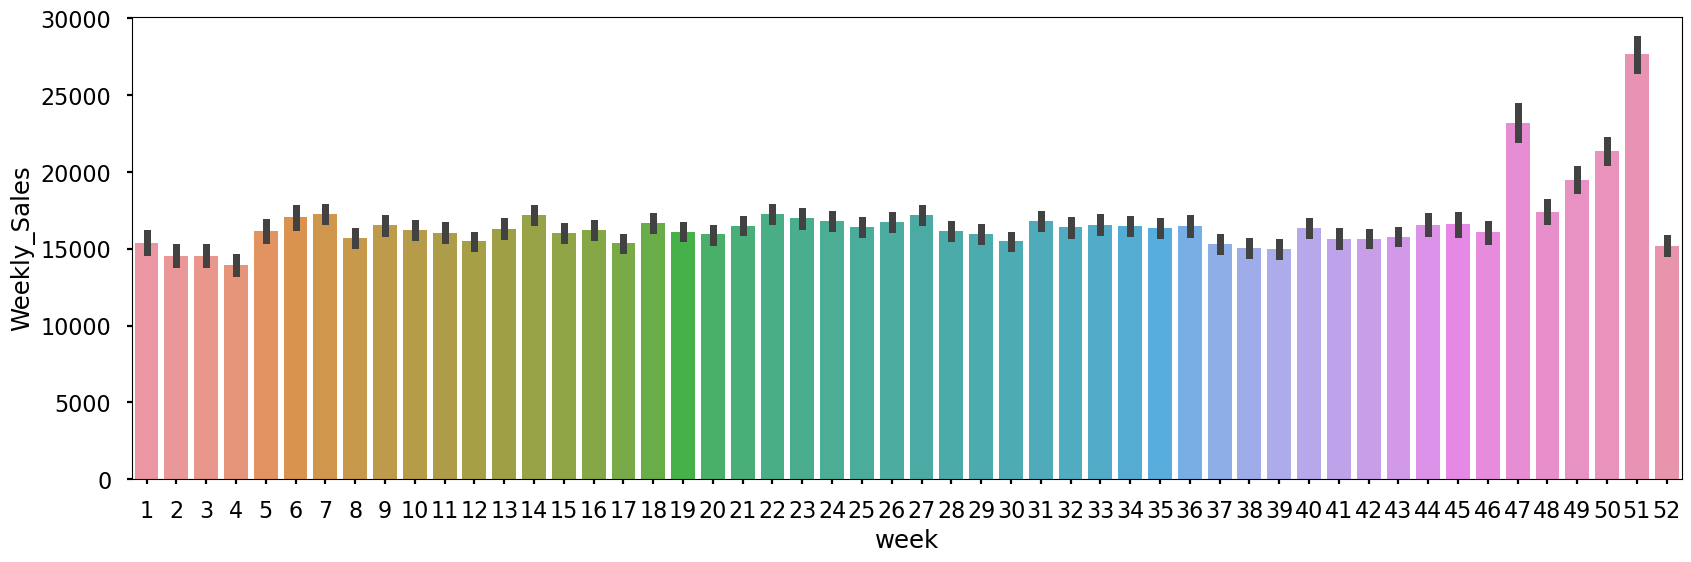

In [78]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

<Axes: xlabel='Unemployment'>

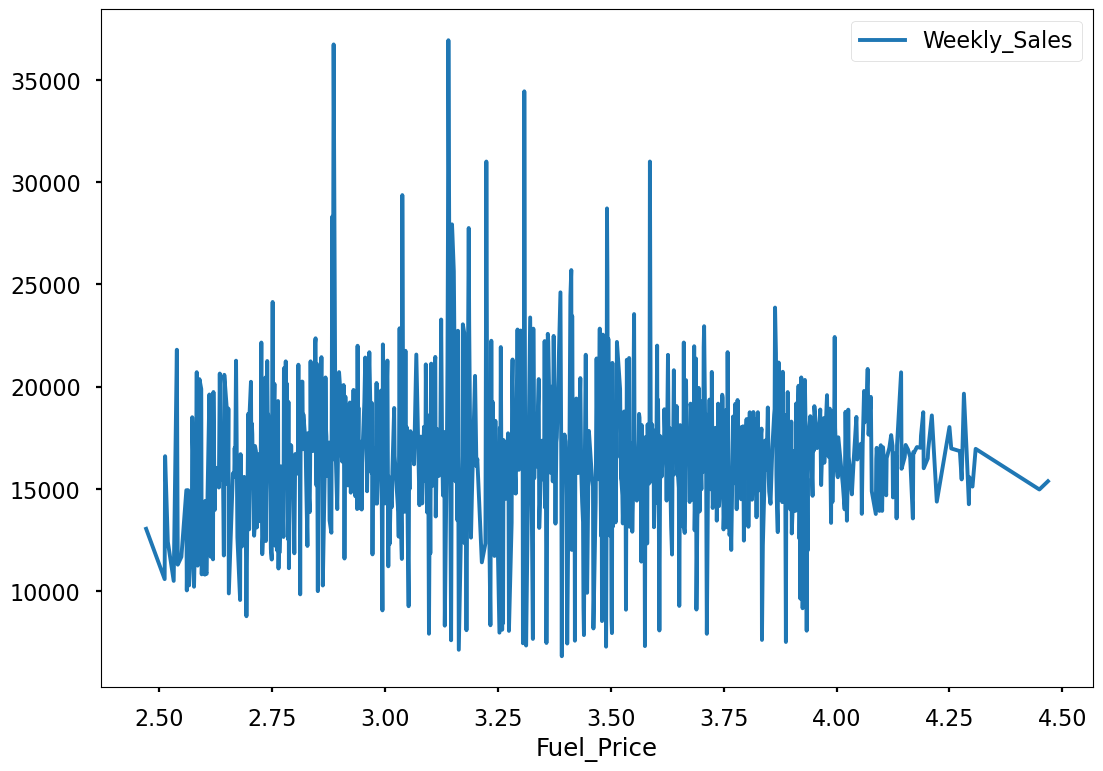

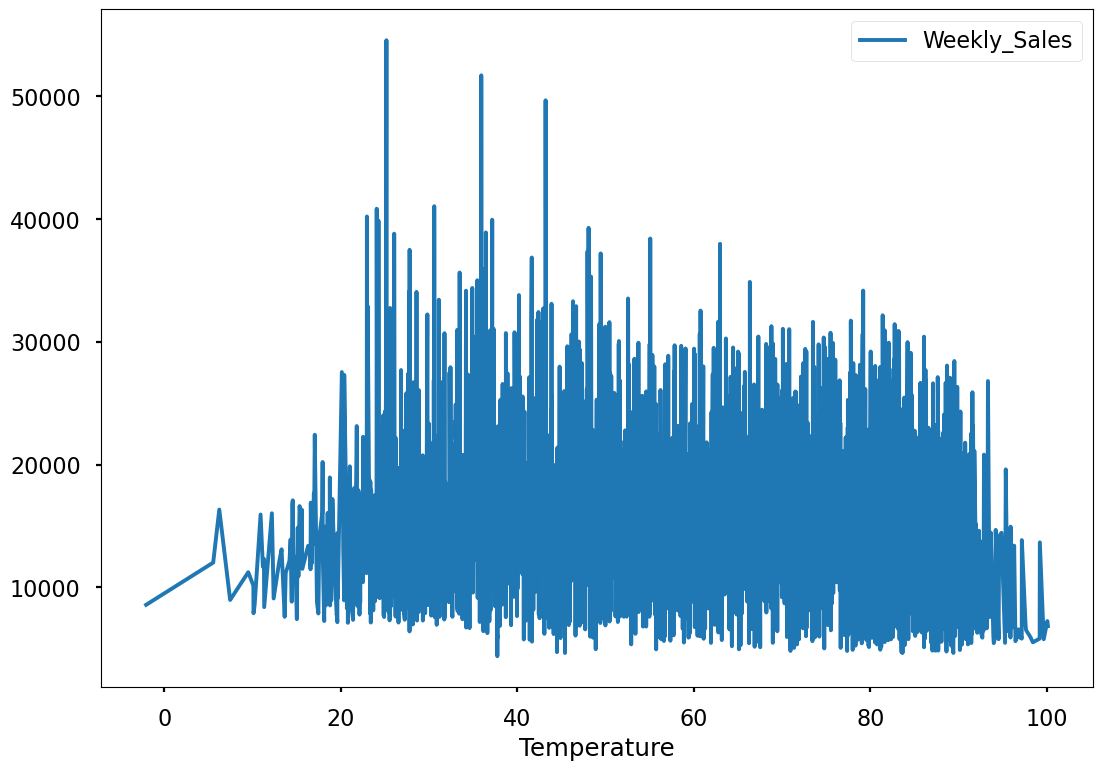

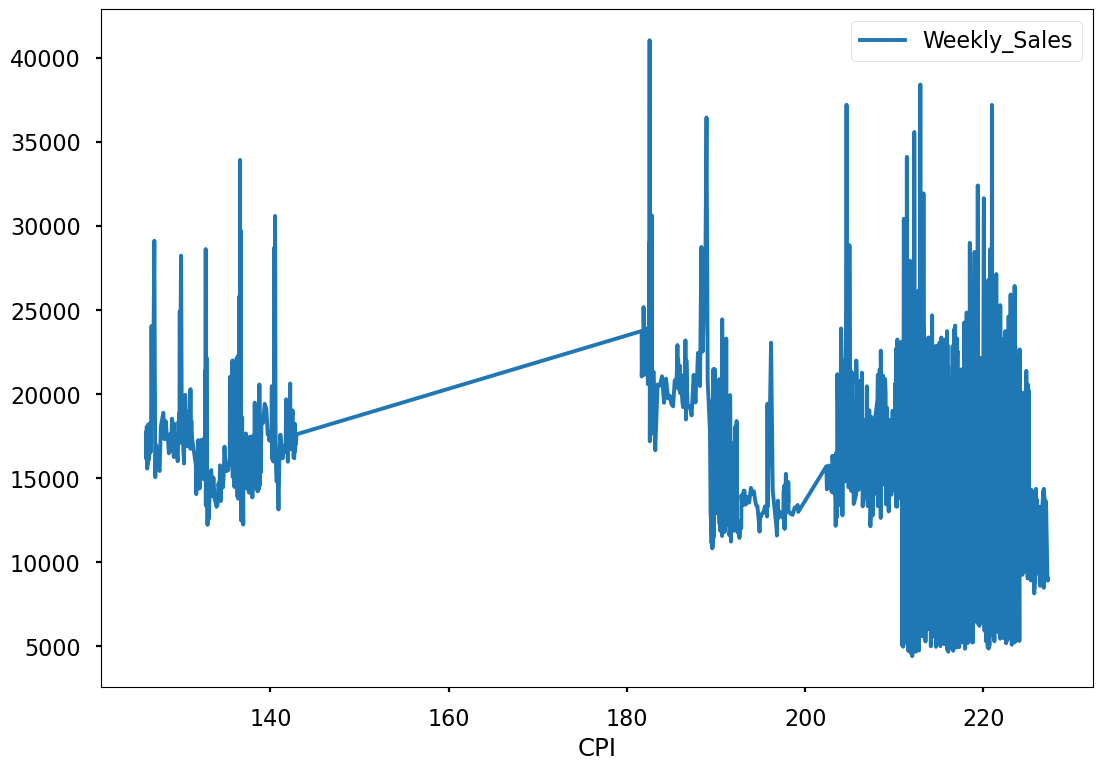

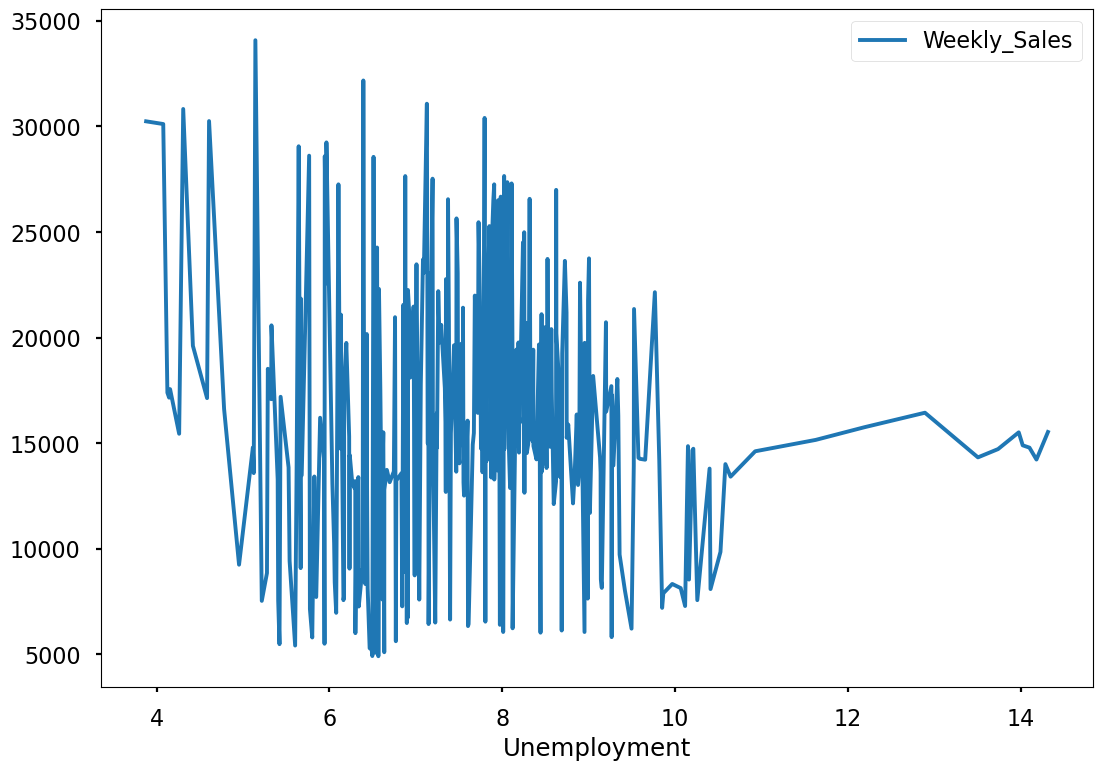

In [79]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

In [80]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

# Evaluation

In [81]:
def cal_mape(df):
    overall_mape = df["gap"].sum()/df["Weekly_Sales"].sum()
    mape_by_week = df.groupby("Date").sum()
    mape_by_week["MAPE"] = mape_by_week["gap"]/mape_by_week["Weekly_Sales"]

    return overall_mape, mape_by_week

# train MAPE calculation
final_forecast_train_df = final_forecast_train_df.reset_index()
final_forecast_train_df = final_forecast_train_df[final_forecast_train_df["Date"]>"2010-02-26"]
final_forecast_train_df["gap"] = abs(final_forecast_train_df["Weekly_Sales"] - final_forecast_train_df["Weekly_Sales_pred"])
output_all_tr_dict.update({"ARIMA": final_forecast_train_df})

mape_df = final_forecast_train_df[final_forecast_train_df["Weekly_Sales"]>0]
overall_mape, mape_by_week = cal_mape(mape_df)
print("overall MAPE =", overall_mape)
print(mape_by_week)

overall MAPE = 0.12823258686548067
                index  Store    Dept  Weekly_Sales  Weekly_Sales_pred  \
Date                                                                    
2010-03-05  536407268  61272  121639   46845058.46       4.391858e+07   
2010-03-12  538171341  61482  122156   45902679.59       4.468841e+07   
2010-03-19  538446070  61555  122182   44961336.74       4.530096e+07   
2010-03-26  538260895  61491  122462   44096608.94       4.443950e+07   
2010-04-02  538499186  61488  122378   50362686.13       4.333044e+07   
...               ...    ...     ...           ...                ...   
2012-08-31  555101107  62681  125027   47150534.40       4.644016e+07   
2012-09-07  557873511  63039  125490   48320689.60       4.597465e+07   
2012-09-14  557733032  63017  125332   44215868.24       4.630338e+07   
2012-09-21  558190034  63007  125461   44336004.16       4.449011e+07   
2012-09-28  557902447  63004  125405   43707995.40       4.325507e+07   

               

In [82]:
# Store output
best_models["ARIMA"] = {"estimator": SARIMAX, "params": {"order": (2,0,0), "seasonal_order":(0,0,0,0)}, "train_score": overall_mape}
# test MAPE calculation
final_forecast_df= final_forecast_df.reset_index()

y_act = te_df[["Store", "Dept", "Weekly_Sales"]].reset_index()
output_all = y_act.merge(final_forecast_df[["Date", "Store", "Dept", "Weekly_Sales_pred"]], on=["Date", "Store", "Dept"], how="left")
output_all["gap"] = abs(output_all["Weekly_Sales"] - output_all["Weekly_Sales_pred"])
output_all_pred_dict.update({"ARIMA": output_all})

mape_df = output_all[output_all["Weekly_Sales"]>0]
overall_mape, mape_by_week = cal_mape(mape_df)
print("overall MAPE =", overall_mape)
print(mape_by_week)

best_models["ARIMA"].update({"test_score": overall_mape})

overall MAPE = 0.12250419439075125
            Store    Dept  Weekly_Sales  Weekly_Sales_pred           gap  \
Date                                                                       
2012-10-05  63020  125487   47521428.20       4.291282e+07  5.473438e+06   
2012-10-12  63007  125418   46078872.70       4.211255e+07  5.468554e+06   
2012-10-19  63065  125503   45073388.03       4.139797e+07  5.153766e+06   
2012-10-26  63013  125397   45480779.78       4.070133e+07  6.463937e+06   

                MAPE  
Date                  
2012-10-05  0.115178  
2012-10-12  0.118678  
2012-10-19  0.114342  
2012-10-26  0.142125  


Some combinations: Non-stationary data > No deep dive

# Elastic Net, RF & LGBM

In [83]:
import lightgbm as lgb

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

# define models as dict
models = {
    "elastic": ElasticNet(),
    "random_forest": RandomForestRegressor(),
    "lightgbm": lgb.LGBMRegressor(),
}

# define hyper parameters for grid search; only 1 param due to high cost of calculation
params = {
    "elastic": {
        "alpha": [0.1, 1],
        # "l1_ratio": [0.3, 0.5],
        # "tol": [0.0001, 0.001],
    },
    "random_forest": {},
    # "random_forest": {}
        # "n_estimators": [50, 100],
        # "max_depth": [10, 15],
    # },
    "lightgbm": {
        "n_estimators": [50, 100],
        # "learning_rate": [0.05, 0.1],
        # "max_depth": [10, 15],
        "verbose": [-1],
    },
}

"""Modules of repeated usage"""
import numpy as np
import pandas as pd

from typing import Union
from sklearn.model_selection import GridSearchCV


def hyperparam_tuning_gs(model, params: dict, X: pd.DataFrame, y: Union[pd.DataFrame, pd.Series, np.array], scoring: str, cv: int = None) -> dict:
    """Hyper parameter tuning by grid search with cross validation.

    Variables
    ----------
    model: Estimator
        Model estimater (initialized one not trained model)
    params: dict
        Hyper paramters
    X: pd.DataFrame
        Dataframe only with feature columns
    y: pd.DataFrame | pd.Series |
        Dataframe only with feature columns
    cv: int
        Number of split for X-validation
    ----------

    Outputs
    ----------
    best_params: dict
        Hyper parameter from the best model
    ----------
    """
    if cv:
        # use when we specific fold numbers for cv
        gridsearch = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring=scoring)
        gridsearch.fit(X, y)
    else:
        # cv = 5 (default) will be applied.
        gridsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring)
        gridsearch.fit(X, y)

    # store best result
    best_est = gridsearch.best_estimator_
    best_params = gridsearch.best_params_
    best_score = gridsearch.best_score_

    print("best params:", best_params)
    print("best_score:", best_score)

    # return best estimator, params and score
    return best_est, best_params, best_score

## Hyper parameter tuning

In [84]:
import time
from sklearn.metrics import mean_absolute_error

best_models = {}
scoring = "neg_mean_absolute_error"  # objective metrics

# loop grid search for parameter tuning
for model, estimator in models.items():
    print(f"Model: {model}")
    start_time = time.time()
    if len(params[model]) == 0:
        print("Hyperparmeters not defined. Training with default params.")
        estimator.fit(X_train, y_train)
        pred_y = estimator.predict(X_train)
        end_time = time.time()
        score = mean_absolute_error(y_train, pred_y) * (-1)
        print("best_score:", score)
        best_models[model] = {"estimator": estimator, "params": {}, "score": score}
        print("Execution time: %s seconds" %(end_time - start_time))
        print(f"-----------")
        continue
    print(params[model])
    best_est, best_params, best_score = hyperparam_tuning_gs(estimator, params[model], X_train, y_train, scoring)
    end_time = time.time()
    best_models[model] = {"estimator": best_est, "params": best_params, "train_score": best_score}
    print("Execution time: %s seconds" %(end_time - start_time))
    print(f"-----------")

Model: elastic
{'alpha': [0.1, 1]}
best params: {'alpha': 0.1}
best_score: -2723.1706473783515
Execution time: 127.6068480014801 seconds
-----------
Model: random_forest
Hyperparmeters not defined. Training with default params.
best_score: -642.4784601310928
Execution time: 475.77767181396484 seconds
-----------
Model: lightgbm
{'n_estimators': [50, 100], 'verbose': [-1]}
best params: {'n_estimators': 100, 'verbose': -1}
best_score: -1850.7398042881996
Execution time: 7.603130102157593 seconds
-----------


In [85]:
# MAPE calculation for overall and by week
for mdl_key in best_models.keys():
    print("Model:", mdl_key)
    model = best_models[mdl_key]["estimator"]
    y_pred = model.predict(X_train)
    y_pred_df = pd.DataFrame(y_pred, index=y_train.index, columns=["Weekly_Sales"])
 
    output_all_tr = tr_df[["Store", "Dept", "Weekly_Sales"]].copy()
    output_all_tr["Weekly_Sales_pred"] = y_pred
    output_all_tr["Weekly_Sales_pred"]= output_all_tr["Weekly_Sales_pred"].where(output_all_tr["Weekly_Sales_pred"]>=0, 0)
    output_all_tr["gap"] = abs(output_all_tr["Weekly_Sales"] - output_all_tr["Weekly_Sales_pred"])
    output_all_tr_dict.update({f"{mdl_key}": output_all_tr})

    mape_df = output_all_tr[output_all_tr["Weekly_Sales"]>0]
    overall_mape, mape_by_week = cal_mape(mape_df)    
    print("overall MAPE =", overall_mape)
    print(mape_by_week["MAPE"])

    best_models[mdl_key].update({"train_score": overall_mape})
    print("------------")

Model: elastic
overall MAPE = 0.13460866984190611
Date
2010-02-19    0.094669
2010-02-26    0.134329
2010-03-05    0.107162
2010-03-12    0.096624
2010-03-19    0.095490
                ...   
2012-08-31    0.096501
2012-09-07    0.149014
2012-09-14    0.131445
2012-09-21    0.100030
2012-09-28    0.082027
Name: MAPE, Length: 137, dtype: float64
------------
Model: random_forest
overall MAPE = 0.03880652657899923
Date
2010-02-19    0.037480
2010-02-26    0.047212
2010-03-05    0.035396
2010-03-12    0.034680
2010-03-19    0.034106
                ...   
2012-08-31    0.034623
2012-09-07    0.046308
2012-09-14    0.039766
2012-09-21    0.032458
2012-09-28    0.028752
Name: MAPE, Length: 137, dtype: float64
------------
Model: lightgbm
overall MAPE = 0.1004315428810325
Date
2010-02-19    0.097178
2010-02-26    0.114744
2010-03-05    0.087917
2010-03-12    0.094300
2010-03-19    0.089452
                ...   
2012-08-31    0.087194
2012-09-07    0.120612
2012-09-14    0.107450
2012-09-21

In [86]:
# multi steps for prediction
def fcst_multisteps(model, pred_iter, df):
    # define min/max date for forecast horizon
    min_date = min(pred_iter) - pd.Timedelta(weeks=max_lags)
    max_date = max(pred_iter)

    # shallow copy
    pred_df = df.copy()
    # extracted data for required period
    df_fcst = pred_df[min_date:max_date]
    # drop lags which will be calculated during iterations
    df_fcst = df_fcst.drop(columns=["Weekly_Sales_lag1", "Weekly_Sales_lag2"])
    # define required columns for otuput
    df_fcst_cols = df_fcst.columns.to_list() + ["Date"]

    for date in pred_iter:
        print("date=", date)
        min_date = date - pd.Timedelta(weeks=max_lags)
        # shallow copy
        slice_df = df_fcst.copy()
        # slice data for prediction for the iteration
        slice_df = slice_df[min_date:date].reset_index()

        # calculate lag feature
        sort_col = "Date"
        grp_col = ["Store", "Dept"]
        cols = ["Weekly_Sales"]
        lags = [1,2]

        # add lag features
        for col in cols:
            slice_df = feature_lag_values(slice_df, sort_col, col, lags, grp_col)
        
        slice_df = slice_df.set_index("Date")
        # extract predicted week
        pred_input_df = slice_df.loc[date].copy()

        X_test_period = pred_input_df.drop(columns=tgt_col, axis=1)
        y_test_period = pred_input_df[tgt_col]

        # prediction
        y_pred_period = model.predict(X_test_period)
        # store prediction into sliced df
        pred_input_df["Weekly_Sales"] = y_pred_period
        pred_input_df["Weekly_Sales"]= pred_input_df["Weekly_Sales"].where(pred_input_df["Weekly_Sales"]>=0, 0)
        pred_output_df_res = pred_input_df[["Store", "Dept", "Weekly_Sales"]].reset_index()
        df_fcst = df_fcst.reset_index()

        # override weekly sales by prediction for next iteration
        df_fcst = pd.merge(df_fcst, pred_output_df_res, on=["Date", "Store", "Dept"], how="left", suffixes=("", "_pred"))
        df_fcst["Weekly_Sales"] = df_fcst["Weekly_Sales_pred"].combine_first(df_fcst["Weekly_Sales"])
        df_fcst = df_fcst[df_fcst_cols]
        df_fcst = df_fcst.set_index("Date")

        # output df        
        if date == min(pred_iter):
            output = pred_output_df_res.set_index("Date")
        else:
            output = pd.concat([output, pred_output_df_res.set_index("Date")], axis=0)

    return output

# Multistep forecast
pred_start_date = "2012-10-05"
pred_end_date = pd.to_datetime(pred_start_date) + pd.Timedelta(weeks=3)
pred_iter = pd.date_range(pred_start_date, pred_end_date,freq="W-FRI")
print(pred_iter)

for mdl_key in best_models.keys():
    print("Model:", mdl_key)
    model = best_models[mdl_key]["estimator"]
    start_time = time.time()
    output = fcst_multisteps(model, pred_iter, df)
    output_all_pred_dict.update({f"{mdl_key}": output})
    end_time = time.time()

    print("Execution time: %s seconds" %(end_time - start_time))
    print("------------")

DatetimeIndex(['2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'], dtype='datetime64[ns]', freq='W-FRI')
Model: elastic
date= 2012-10-05 00:00:00
date= 2012-10-12 00:00:00
date= 2012-10-19 00:00:00
date= 2012-10-26 00:00:00
Execution time: 0.24286174774169922 seconds
------------
Model: random_forest
date= 2012-10-05 00:00:00
date= 2012-10-12 00:00:00
date= 2012-10-19 00:00:00
date= 2012-10-26 00:00:00
Execution time: 3.3305301666259766 seconds
------------
Model: lightgbm
date= 2012-10-05 00:00:00
date= 2012-10-12 00:00:00
date= 2012-10-19 00:00:00
date= 2012-10-26 00:00:00
Execution time: 0.153764009475708 seconds
------------


In [87]:
# MAPE evaluation for prediction
for mdl_key in best_models.keys():
    print("Model:", mdl_key)
    prc_df = output_all_pred_dict[mdl_key]
    prc_df.rename(columns={"Weekly_Sales": "Weekly_Sales_pred"}, inplace=True)

    output_all = pd.concat([y_test, prc_df["Weekly_Sales_pred"]], axis=1)
    output_all["gap"] = abs(output_all["Weekly_Sales"] - output_all["Weekly_Sales_pred"])
    output_all_pred_dict.update({f"{mdl_key}": output_all})

    mape_df = output_all[output_all["Weekly_Sales"]>0]
    overall_mape, mape_by_week = cal_mape(mape_df)  
    print("overall MAPE =", overall_mape)
    print(mape_by_week["MAPE"])

    best_models[mdl_key].update({"test_core": overall_mape})
    print("------------")

Model: elastic
overall MAPE = 0.1444108495216879
Date
2012-10-05    0.121778
2012-10-12    0.133589
2012-10-19    0.148434
2012-10-26    0.175036
Name: MAPE, dtype: float64
------------
Model: random_forest
overall MAPE = 0.10166263233276279
Date
2012-10-05    0.087511
2012-10-12    0.097947
2012-10-19    0.101813
2012-10-26    0.120065
Name: MAPE, dtype: float64
------------
Model: lightgbm
overall MAPE = 0.10126139034155067
Date
2012-10-05    0.084667
2012-10-12    0.097440
2012-10-19    0.103538
2012-10-26    0.120216
Name: MAPE, dtype: float64
------------


- Hyper parameter tuning not fully done; RF took longer time, so tuning was not tried.

# LSTM

In [88]:
# Function to create sequences for each store-dept combination
def create_sequences(data, time_steps, drop_cols):
    sequences = []
    output_list = []
    for seq, df in data.groupby(["Store", "Dept"]):
        process_df = df.reset_index(drop=True)
        features = process_df.drop(columns=drop_cols).values
        labels = process_df["Weekly_Sales"].values
        for i in range(len(df) - time_steps):
            feature = features[i:(i + time_steps)]
            label = labels[i + time_steps] 
            sequences.append((feature, label))
            output_list.append({"Date": df.index[i+time_steps], "Store": df["Store"].iloc[i+time_steps], "Dept": df["Dept"].iloc[i+time_steps], "Weekly_Sales": df["Weekly_Sales"].iloc[i+time_steps]})
    return sequences, output_list
# Create sequences with time_steps=2
time_steps = 2
# Shallow copy
tr_df_sc = tr_df.copy()

# MinMax scaler for feature and target
sc_col = ['Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'year', 'quarter', 'month', 'week']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))
tr_df_sc[sc_col] = scaler.fit_transform(tr_df_sc[sc_col])
tr_df_sc[["Weekly_Sales"]] = scaler1.fit_transform(tr_df_sc[["Weekly_Sales"]])

drop_cols = ["Store", "Dept", "Weekly_Sales_lag1", "Weekly_Sales_lag2"]
sequences, output_list = create_sequences(tr_df_sc, time_steps, drop_cols)
output = pd.DataFrame(output_list)

# # Display the sequences
# for i, (seq, label) in enumerate(sequences):
#     print(f"Sequence {i+1}: Input: {seq}, Output (Sales): {label}")

# create sequences
X, y = zip(*sequences)
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(384090, 2, 30)
(384090,)


In [89]:
!pip install tensorflow pandas numpy scikit-learn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [90]:
# Select features and target
features = ['Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'year', 'quarter', 'month', 'week']
target = 'Weekly_Sales'

# Scale features and target
scaler = MinMaxScaler(feature_range=(0, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))

tr_df_sc = tr_df.copy()
tr_df_sc[features] = scaler.fit_transform(tr_df_sc[features])
tr_df_sc[[target]] = scaler1.fit_transform(tr_df_sc[[target]])

# Create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 2
data = tr_df_sc[features + [target]].values
X, y = create_sequences(data, time_steps)


In [91]:
!pip install --upgrade tensorflow numpy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, len(features))),
    LSTM(128),
    Dense(1)
])

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

# Define callbacks

  Using cached numpy-2.2.4-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [92]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import keras

n_units=128
batch_size=32
n_epochs=20
patience=5

# define LSTM model; simple one
model = Sequential()
model.add(LSTM(units=n_units, return_sequences=True, input_shape = (time_steps, X.shape[2])))
# model.add(Dropout(0.5))
model.add(LSTM(units=n_units))
# model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', 
              metrics=['mae'],
              optimizer="adam")
model.summary()

start_time = time.time()
history = model.fit(
    X,
    y,
    epochs=n_epochs,
    batch_size=batch_size,
    callbacks=[
        ReduceLROnPlateau(), 
        EarlyStopping(monitor='loss', mode='min', verbose=1, patience=patience)],
    verbose=1, 
    shuffle=False
)

end_time = time.time()
print("Execution time: %s seconds" %(end_time - start_time))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 2, 128)         │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,441 (802.50 KB)

 Trainable params: 205,441 (802.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.0195 - mae: 0.0195 - learning_rate: 0.0010
Epoch 2/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 3/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 4/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 5/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 6/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 7/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 8/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 9/20
12182/12182 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0194 - mae: 0.0194 - learning_rate: 0.0010
Epoch 10/2

In [97]:
# Make predictions
y_pred = model.predict(X)

# Inverse transform the predicted values
y_pred_inv = scaler1.inverse_transform(y_pred)

# Ensure the length of `y_pred_inv` matches `output`
if len(y_pred_inv) == len(output):
    output["Weekly_Sales_pred"] = y_pred_inv
else:
    # Trim or pad y_pred_inv to match the length of output
    min_len = min(len(y_pred_inv), len(output))
    output = output.iloc[:min_len].copy()  # Trim output to match prediction length
    output["Weekly_Sales_pred"] = y_pred_inv[:min_len]

# Inverse transform actual sales
output["Weekly_Sales"] = scaler1.inverse_transform(output[["Weekly_Sales"]])

# Compute the absolute gap
output["gap"] = abs(output["Weekly_Sales"] - output["Weekly_Sales_pred"])

# Store the results in dictionary
output_all_tr_dict.update({"LSTM": output})


12182/12182 ━━━━━━━━━━━━━━━━━━━━ 8s 690us/step


In [98]:
# MAPE calcuation for train data
mape_df = output[output["Weekly_Sales"]>0]
overall_mape, mape_by_week = cal_mape(mape_df)  
print("overall MAPE =", overall_mape)
print(mape_by_week)

# Store output
best_models["LSTM"] = {"estimator": model, "params": {"epoch": n_epochs, "batch_size": batch_size}, "train_score": overall_mape}

overall MAPE = 1.0
            Store    Dept  Weekly_Sales  Weekly_Sales_pred           gap  MAPE
Date                                                                          
2010-03-05  61170  121524  1.559724e+25         20197516.0  1.559724e+25   1.0
2010-03-12  61413  122118  1.528355e+25         20262884.0  1.528355e+25   1.0
2010-03-19  61495  122102  1.497012e+25         20277410.0  1.497012e+25   1.0
2010-03-26  61475  122402  1.468222e+25         20284672.0  1.468222e+25   1.0
2010-04-02  61472  122298  1.676854e+25         20284670.0  1.676854e+25   1.0
...           ...     ...           ...                ...           ...   ...
2012-08-31  62662  124988  1.569904e+25         20626016.0  1.569904e+25   1.0
2012-09-07  63020  125451  1.608865e+25         20713168.0  1.608865e+25   1.0
2012-09-14  63017  125332  1.472193e+25         20705906.0  1.472193e+25   1.0
2012-09-21  63007  125461  1.476193e+25         20720430.0  1.476193e+25   1.0
2012-09-28  63004  125405  1.4552

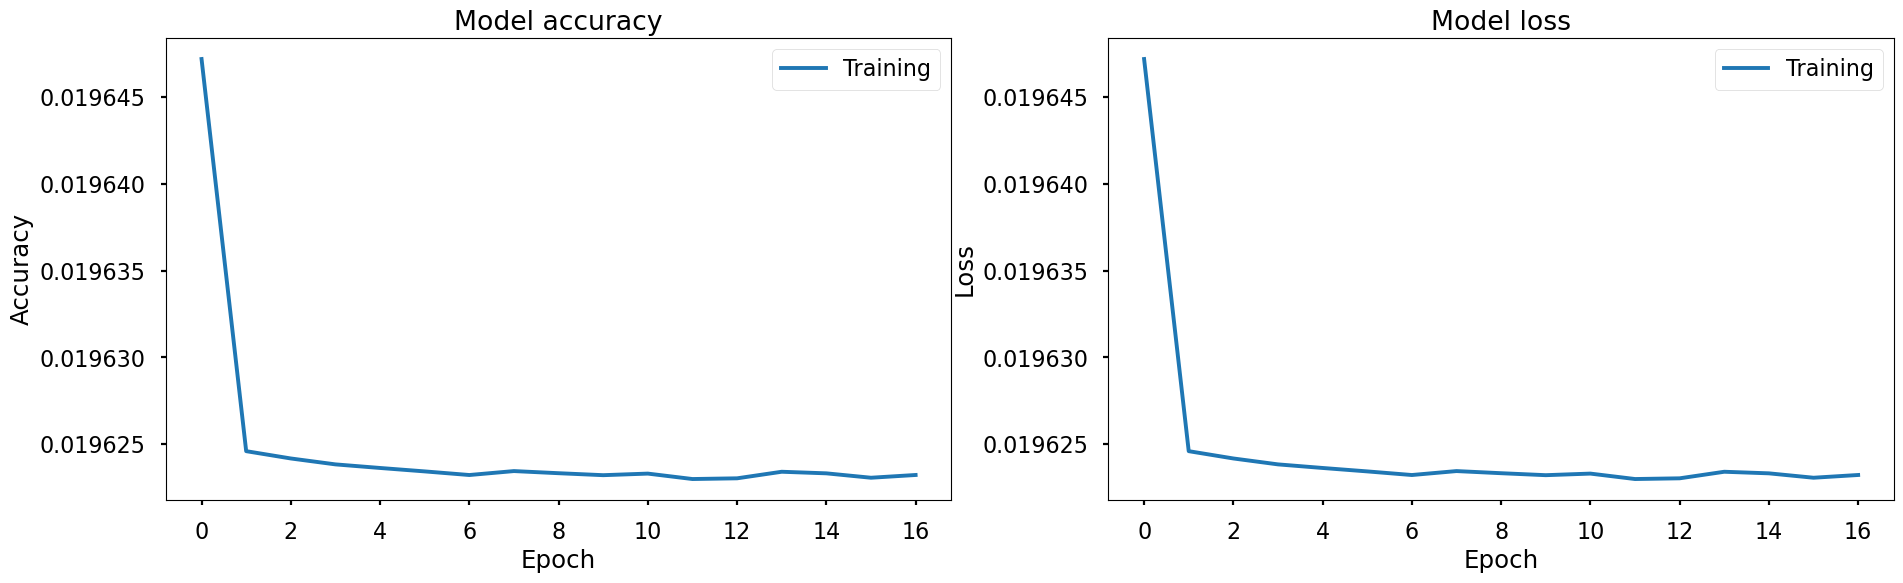

In [99]:
# Display learning curves
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(history.history['mae'], label = 'Training')
# ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(history.history['loss'], label = 'Training')
# ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

# Model selection

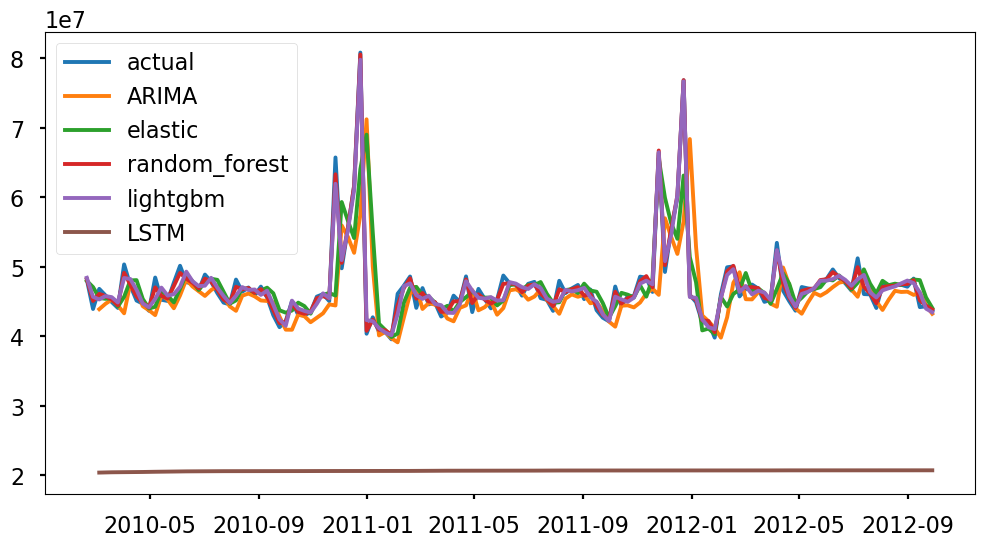

In [100]:
train_plot = y_train.groupby("Date").sum()
# pred_plot = y_pred_df.groupby("Date").sum()

plt.figure(figsize=(12,6))
plt.plot(train_plot.index, train_plot, label="actual")
for key, data in output_all_tr_dict.items():
    pred_plot = data.groupby("Date").sum()
    plt.plot(pred_plot.index, pred_plot["Weekly_Sales_pred"], label=f"{key}")
plt.legend()
plt.show()

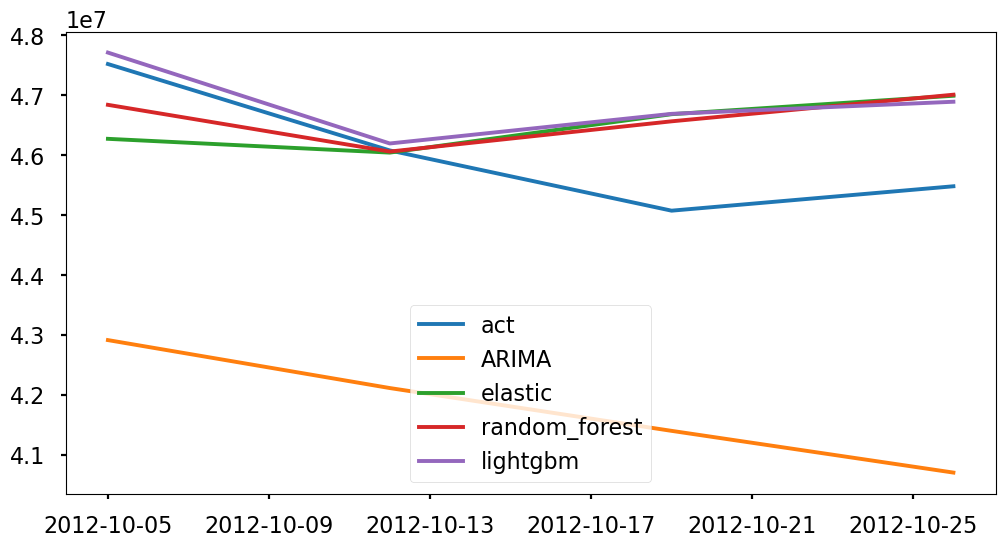

In [101]:
test_plot = y_test.groupby("Date").sum()
# pred_plot = output_all.groupby("Date")["Weekly_Sales_pred"].sum()

plt.figure(figsize=(12,6))
plt.plot(test_plot.index, test_plot, label="act")
for key, data in output_all_pred_dict.items():
    pred_plot = data.groupby("Date").sum()
    plt.plot(pred_plot.index, pred_plot["Weekly_Sales_pred"], label=f"{key}")
plt.legend()
plt.show()

In [102]:
best_models

{'elastic': {'estimator': ElasticNet(alpha=0.1),
  'params': {'alpha': 0.1},
  'train_score': 0.13460866984190611,
  'test_core': 0.1444108495216879},
 'random_forest': {'estimator': RandomForestRegressor(),
  'params': {},
  'score': -642.4784601310928,
  'train_score': 0.03880652657899923,
  'test_core': 0.10166263233276279},
 'lightgbm': {'estimator': LGBMRegressor(verbose=-1),
  'params': {'n_estimators': 100, 'verbose': -1},
  'train_score': 0.1004315428810325,
  'test_core': 0.10126139034155067},
 'LSTM': {'estimator': <Sequential name=sequential_1, built=True>,
  'params': {'epoch': 20, 'batch_size': 32},
  'train_score': 1.0}}

## From above I came to the conclusion that:

### Light GBM would be the best model, Because:
1) Reliable accuracy (MAPE) ~ 1x%
2) Silimar accuracy on train/test data
3) Fast

### The below are the all explanations and findings from this project

# Findings and Explorations¶

### Cleaning: -

#The data has no too much missing values. All columns was checked.

#I choose rows which has higher than 0 weekly sales. Minus values are 0.3% of data. So, I dropped them.

#Null values in markdowns changed to zero. Because, they were written as null if there were no markdown on this department.

# Explorations & Findings

The dataset includes 45 stores and 81 departments, though not all departments are present in every store. While Department 72 records the highest weekly sales at certain times, Department 92 has the highest average sales overall. This suggests that some departments experience seasonal peaks, such as during Thanksgiving. This trend is reinforced by the top five sales in the dataset, all of which belong to Department 72 during the Thanksgiving holiday.  

Stores 10 and 35 occasionally report high weekly sales, but on average, Store 20 and Store 4 consistently rank first and second, respectively. This indicates that certain regions experience seasonal sales surges. Stores are categorized into three types—A, B, and C—based on size, with nearly half exceeding 150,000 square feet and classified as Type A. Sales performance varies accordingly by store type. As expected, holiday periods see higher average sales compared to regular days.  

Although Christmas falls at the end of the year, peak shopping activity occurs in the 51st week. Among all holidays, Thanksgiving records the highest sales, as designated by Walmart. Sales in 2010 were higher than in 2011 and 2012. However, the dataset does not include November and December sales for 2012. Given that these months typically yield the highest sales, their inclusion could position 2012 as the leading sales year.  

Weeks 51 and 47 show the highest sales figures, followed closely by weeks 50 through 48. Interestingly, the fifth-highest sales period falls in week 22, around late May, likely due to school closures and preparations for summer holidays. January sales are noticeably lower than in other months, likely following the heavy spending seen in November and December.  

There is no discernible pattern between weekly sales and factors such as CPI, temperature, unemployment rate, or fuel prices.